In [1]:
#export
"""`k1ui <https://github.com/157239n/k1ui>`_ is another project made in Java that
aims to record and manipulate the screen, keyboard and mouse. The interface to
that project on its own is clunky, and this module is the Python interface to
ease its use.

Not quite developed yet tho, because I'm lazy."""
import k1lib, numpy as np, asyncio, time, inspect, json, threading, dill, math, base64, requests, os, random, warnings
k1 = k1lib; cli = k1.cli; from k1lib.cli import *; knn = k1.knn; Cbs = k1.Cbs; viz = k1.viz; websockets = k1.dep("websockets")
torch = k1.dep("torch"); nn = k1.dep("torch.nn"); optim = k1.dep("torch.optim"); tf = k1.dep("torchvision.transforms")
PIL = k1.dep("PIL"); k1.dep("graphviz")
from typing import Callable, List, Iterator, Tuple, Union, Dict; from collections import defaultdict, deque; from functools import lru_cache
import matplotlib as mpl; import matplotlib.pyplot as plt
__all__ = ["get", "WsSession", "selectArea", "record", "execute", "Recording",
           "Track", "CharTrack", "WordTrack", "ContourTrack", "ClickTrack", "WheelTrack", "StreamTrack",
           "distNet", "TrainScreen"]

Potential future ideas:
- make functions to edit the tracks easily:
    - move a group of tracks left or right. Means have to introduce groups and whatnot. Can be nested
- test higher resolutions, to see where's the limit in terms of fps
- create video tutorials on everything, but now do it properly, demonstrating all features of k1ui:
    - searching for videos on youtube, replacing text, wait for stream to begin
    - writing vnmese/russian, delete time, faster typing speed

In [2]:
init.patchNumpy()

In [3]:
#export
k1lib.settings.add("k1ui", k1.Settings().add("server", k1.Settings().add("http", "http://localhost:9511", "normal http server").add("ws", "ws://localhost:9512", "websocket server"), "server urls"), "docs related to k1ui java library");
settings = k1lib.settings.k1ui
settings.add("draw", k1.Settings(), "drawing settings")
settings.draw.add("trackHeight", 30, "Track's height in Recording visualization")
settings.draw.add("pad", 10, "Padding between tracks");
def get(path):
    """Sends a get request to the Java server.
Example::

    k1ui.get("mouse/200/300") # move mouse to (200, 300)"""
    return requests.get(f"{settings.server.http}/{path}", timeout=60*10).text
def post(path, jsObj):
    """Sends a post request to the Java server.
Example::

    k1ui.post("mouse/200/300") # move mouse to (200, 300)"""
    return requests.post(f"{settings.server.http}/{path}", json=jsObj, timeout=60*10).text

In [4]:
#export
portAutoInc = k1.AutoIncrement(9520)
class WsSession:
    def __init__(self, eventCb:Callable[["WsSession", dict], None], mainThreadCb:Callable[["WsSession"], None]):
        """Creates a websocket connection with the server, with some callback functions

The callback functions (most are async btw) will be passed a WebSocket object
as the first argument. You can use it to send messages like this::

    # this will send a signal to the server to close the session
    sess.ws.send(json.dumps({"type": "close"}))
    # this will send a signal to the server requesting the current screenshot. Result will be deposited into eventCb
    sess.ws.send(json.dumps({"type": "screenshot"}))
    # this will execute a single event
    sess.ws.send(json.dumps({"type": "execute", "event": {"type": "keyTyped", "javaKeyCode": 0, ...}}))

Complete, minimum example::

    events = []
    async def eventCb(sess, event): events.append(event)
    async def mainThreadCb(sess):
        sess.stream(300) # starts a stream with output screen width of 300px
        await asyncio.sleep(2)
        await sess.ws.send(json.dumps({"type": "execute", "event": {"type": "keyPressed", "javaKeyCode": 65, "timestamp": 0}}))
        await sess.ws.send(json.dumps({"type": "execute", "event": {"type": "keyReleased", "javaKeyCode": 65, "timestamp": 0}}))
        await asyncio.sleep(10); sess.close()
    await k1ui.WsSession(eventCb, mainThreadCb).run()

What this code does is that it will communicate with the server continuously for 12
seconds, capturing all events in the mean time and save them into ``events`` list.
It will start up a UDP stream to capture screenshots continuously, and after 2 seconds,
it sends 2 events to the server, trying to type the letter "A". Finally, it waits for
another 10 seconds and then terminates the connection.

This interface is quite low-level, and is the basis for all other functionalities.
Some of them include:

* :meth:`record`: recording a session
* :meth:`execute`: executes a list of events

:param eventCb: (async) will be called whenever there's a new event
:param mainThreadCb: (async) will be called after setting up everything
:param streamWidth: specifies the width of the UDP stream, in pixels"""
        self.ws = None; self.eventCb = eventCb; self.mainThreadCb = mainThreadCb
        if not inspect.iscoroutinefunction(eventCb): raise Exception(f"eventCb has to be an async function")
        if not inspect.iscoroutinefunction(mainThreadCb): raise Exception(f"mainThreadCb has to be an async function")
        self.closed = False; self.streams = {} # width -> [width, lock, port]
    async def _listenLoop(self):
        while True:
            res = await self.ws.recv() | cli.aS(json.loads); _type = res["type"]
            if _type == "close": break # python sends close signal to java, java then sends a close signal back, as an acknowledgement
            if _type == "screenshot": await self.eventCb(self, {"type": "screenshot", "bytes": base64.b64decode(res["screenshot"]), "timestamp": int(time.time()*1000)})
            if _type == "newEvent": await self.eventCb(self, res["event"])
    async def _pingLoop(self):
        while True:
            if self.closed: break
            try: await self.ws.send({"type": "ping"} | cli.aS(json.dumps)); await asyncio.sleep(1)
            except: break
    async def _streamLoop(self, width, locks, port):
        import cv2; streamRefresh = 100 # refreshes udp stream after this many seconds, so that it doesn't hang
        def threadLoop(lock, port):
            with lock, k1.captureStdout(False, True):
                get(f"startStream/{width}/{port}"); cap = cv2.VideoCapture(f'udp://0.0.0.0:{port}', cv2.CAP_FFMPEG); beginTime = time.time()
                while (cap.isOpened()):
                    if self.closed: break
                    res, frame = cap.read()
                    if not res: break
                    self.loop.create_task(self.eventCb(self, {"type": "stream", "width": width, "frame": frame[:,:,::-1], "timestamp": int(time.time()*1000)}))
                    if time.time() - beginTime > streamRefresh + 10: break # there will be a short time (5s) where there're 2 udp streams simultaneously dumps events
                cap.release(); get(f"stopStream/{port}")
        ports = [port, port + 100]; sel = 0
        while not self.closed:
            threading.Thread(target=threadLoop, args=(locks[sel], ports[sel])).start()
            await asyncio.sleep(streamRefresh); sel = 1-sel
    def stream(self, width):
        """Starts a stream with a particular output width. The lower the width, the higher the fps and vice versa"""
        if width in self.streams: raise Exception(f"Can't start stream with width {width}. Just use the existing stream.")
        port = portAutoInc()
        self.streams[width] = [width, [threading.Lock(), threading.Lock()], port]; import cv2 # placed here so that users can see error message if cv2 is not imported
        asyncio.create_task(self._streamLoop(*self.streams[width]))
    async def run(self):
        """Connects with Java server, set things up and runs ``mainThreadCb``"""
        async with websockets.connect(settings.server.ws, max_size=1_000_000_000) as ws:
            self.ws = ws; self.loop = asyncio.get_event_loop()
            _listenLoop = asyncio.create_task(self._listenLoop())
            _pingLoop = asyncio.create_task(self._pingLoop());
            try: await self.mainThreadCb(self)
            except asyncio.CancelledError: self.close()
            await _listenLoop
    def close(self):
        """Closes the connection with the Java server"""
        if self.closed: print("Already closed"); return
        self.closed = True; asyncio.create_task(self.ws.send({"type": "close"} | cli.aS(json.dumps)))
        for width, locks, port in self.streams.values():
            with locks[0]: # make sure all locks are freed. Also important to have the 2 locks be nested in each other, in case everything aligns just right that evades this mechanism
                with locks[1]: pass
    async def execute(self, events):
        """Executes a series of events"""
        events = events | sortF(op()["timestamp"]) | aS(list)
        deltaT = int(time.time()*1000) - events[0]["timestamp"]
        for e in events | apply(lambda x: {**x, "timestamp": x["timestamp"]+deltaT}):
            st = e["timestamp"]/1000 - time.time()
            if st > 0: await asyncio.sleep(st)
            await self.ws.send(json.dumps({"type": "execute", "event": e}))

In [5]:
events = []
async def eventCb(sess, event): events.append(event)
async def mainThreadCb(sess):
    sess.stream(300) # starts a stream with output screen width of 300px
    await asyncio.sleep(1)
    await sess.ws.send(json.dumps({"type": "execute", "event": {"type": "keyPressed", "javaKeyCode": 16, "timestamp": 0}}))
    await sess.ws.send(json.dumps({"type": "execute", "event": {"type": "keyReleased", "javaKeyCode": 16, "timestamp": 0}}))
    await asyncio.sleep(1); sess.close()
await WsSession(eventCb, mainThreadCb).run()
assert len(events) > 0; del events

In [6]:
#export
def selectArea(x, y, w, h):
    """Selects an area on the screen to focus into"""
    return get(f"selectArea/{x}/{y}/{w}/{h}")
async def record(t=None, keyCode=None, streamWidth=300, f=iden()):
    """Records activities.
Examples::

    events = await k1ui.record(t=5) # records for 5 seconds
    events = await k1ui.record(keyCode=5) # records until "Escape" is pressed
    events = await k1ui.record() # records until interrupt signal is sent to the process

Note: these examples only work on jupyter notebooks. For regular Python processes,
check out official Python docs (https://docs.python.org/3/library/asyncio-task.html)

:param t: record duration
:param keyCode: key to stop the recording
:param streamWidth: whether to opens the UDP stream and capture screenshots at this width or not
:param f: extra event post processing function"""
    events = []
    async def eventCb(sess, event):
        res = f(event)
        if res is not None: events.append(res)
        if event["type"] == "keyReleased" and event["keyCode"] == keyCode: sess.close()
    async def mainThreadCb(sess):
        if streamWidth: sess.stream(streamWidth)
        if t is not None: await asyncio.sleep(t); sess.close()
        else: await asyncio.sleep(1e9)
    await WsSession(eventCb, mainThreadCb).run(); return events
async def execute(events:List[dict]):
    """Executes some events"""
    async def eventCb(sess, event): pass
    async def mainThreadCb(sess): await sess.execute(events); sess.close()
    await WsSession(eventCb, mainThreadCb).run()

In [7]:
selectArea(2560, 0, 2560, 1440) # for my own screen

'{"message":"ok"}'

In [8]:
#export
uuid = k1.AutoIncrement(random.randint(0, int(1e9)), prefix="k1ui-")
def escapeHtml(s): return s.replace("&", "&amp;").replace("<", "&lt;").replace(">", "&gt;")
class HtmlView:
    def __init__(self, html): self.html = html
    def _repr_html_(self): return self.html
class Recording:
    def __init__(self, events):
        self.uuid = uuid(); self._tracks = []
        if len(events) == 0: return # shortcut to initialize using cloned tracks rather than events
        events = events | sortF(op()["timestamp"]) | deref()
        self._tracks.extend(ContourTrack.parse(events))
        self._tracks.extend(CharTrack.parse(events))
        self._tracks.extend(ClickTrack.parse(events))
        self._tracks.extend(WheelTrack.parse(events))
        self._tracks.extend(StreamTrack.parse(events))
        self._tracks = self._tracks | filt(op()) | apply(lambda x: x._rec(self)) | deref()
        self._resetTimes(); self._resetDis()
    def _resetTimes(self): self.startTime, self.endTime = self._tracks | op().timeUnix().all() | joinStreams() | filt(op()) | toMin() & toMax(); return self
    def _resetDis(self): self.dis1, self.dis2 = (self.startTime+self.endTime)/2 | aS(lambda x: [x-self.duration*0.53, x+self.duration*0.53]); return self # display times
    @property
    def duration(self): return self.endTime - self.startTime
    def addTracks(self, *tracks) -> "Recording":
        """Adds tracks to the Recording"""
        if not isinstance(tracks[0], Track) and len(tracks) == 1: tracks = tracks[0]
        self._tracks.extend(tracks | apply(lambda tr: tr._rec(self))); self._resetTimes(); self._resetDis(); return self
    def removeTracks(self, *tracks) -> "Recording":
        """Removes tracks from the Recording"""
        if not isinstance(tracks[0], Track) and len(tracks) == 1: tracks = tracks[0]
        tracks | apply(self._tracks.remove) | ignore(); self._resetTimes(); self._resetDis(); return self
    def _normTime(self, t=None, default=None): return default if t is None else t + self.startTime
    def zoom(self, t1=None, t2=None):
        """Zooms into a particular time range. If either bounds are not
specified, they will default to the start and end of all events.

:param t1: time values are relative to the recording's start time"""
        _dis1 = self.dis1; t1 = _dis1 if t1 is None else t1 + self.startTime
        _dis2 = self.dis2; t2 = _dis2 if t2 is None else t2 + self.startTime
        delta = t2-t1; t1-=delta*0.03; t2+=delta*0.03; self.dis1 = t1; self.dis2 = t2
        html = self._repr_html_(); self.dis1 = _dis1; self.dis2 = _dis2; return HtmlView(html)
    def sel(self, t1=None, t2=None, klass=None) -> List["Track"]:
        """Selects a subset of tracks using several filters.

For selecting time, assuming we have a track that looks like
this (x, y are t1, t2)::

    # |-1--|   |-2-|
    #    |---3---|
    #  x     y

Then, tracks 1 and 3 are selected. Time values are relative to
recording's start time

:param t1: choose tracks that happen after this time
:param t2: choose tracks that happen before this time
:param klass: choose specific track class"""
        tracks = self._tracks
        if klass: tracks = tracks | instanceOf(klass)
        if t1 is not None or t2 is not None:
            t1 = self._normTime(t1, self.startTime); t2 = self._normTime(t2, self.endTime)
            tracks = tracks | apply(lambda o: [o.startTime or 0, o.endTime, o]) | ~filt(op()[1]<t1) | ~filt(op()[0]>=t2) | cut(2)
        return tracks | aS(list)
    def sel1(self, **kwargs) -> List["Track"]:
        """Like :meth:`sel`, but this time gets the first element only."""
        return self.sel(**kwargs) | item()
    def time0(self) -> List[float]:
        """Start and end recording times. Start time is zero"""
        return [0, self.endTime - self.startTime]
    def timeUnix(self) -> List[float]:
        """Start and end recording times. Both are absolute unix times"""
        return [self.startTime, self.endTime]
    def events(self) -> List[dict]:
        """Reconstructs events from the Recording's internal data.
The events are lossy though::

    events = ... # events recorded
    r = k1ui.Recording(events)
    assert r.events() != events # this is the lossy part. Don't expect the produced events match exactly with each other"""
        return self._tracks | op().events().all() | joinStreams() | sortF(op()["timestamp"]) | deref(igT=False)
    def copy(self) -> "Recording":
        """Creates a clone of this recording"""
        return Recording([]).addTracks(self._tracks | op().copy().all())._resetDis()
    def _repr_html_(self): return self | aS(createTrackss) | aS(drawTrackss)

In [9]:
#export
class Track:
    def __init__(self, startTime, endTime):
        """Time values are absolute unix time."""
        self.recording = None; self.startTime = startTime if startTime else None; self.endTime = endTime; self.uuid = uuid()
    def time0(self) -> List[float]:
        """Start and end track times. Times are relative to track's start time"""
        return [0, self.endTime - self.startTime]
    def time0Rec(self) -> List[float]:
        """Start and end track times. Times are relative to recording's start time"""
        return [self.startTime-self.recording.startTime if self.startTime else None, self.endTime-self.recording.startTime]
    def timeUnix(self) -> List[float]:
        """Start and end track times. Times are absolute unix times"""
        return [self.startTime, self.endTime]
    def concurrent(self) -> List["Track"]:
        """Grabs all tracks that are concurrent to this track"""
        return self.recording.sel(*self.time0Rec())
    def _rec(self, recording): self.recording = recording; return self # inject dependency
    def _tooltip(self, ctx): return ""
    def _displayTimes(self): # shortcut func for displaying in __repr__
        s = f"{self.startTime-self.recording.startTime:.2f}s" if self.startTime else None
        e = f"{self.endTime-self.recording.startTime:.2f}s"; return f"time ({s}->{e})"
    def events(self) -> List[dict]:
        """Reconstructs events from the Track's internal data, to be implemented by subclasses."""
        return NotImplemented
    def copy(self):
        """Creates a clone of this Track, to be implemented by subclasses"""
        return NotImplemented
    def move(self, deltaTime):
        """Moves the entire track left or right, to be implemented by subclasses.

:param deltaTime: if negative, move left by this number of seconds, else move right"""
        self.startTime += deltaTime; self.endTime += deltaTime; self.recording._resetTimes(); self.recording._resetDis()

In [10]:
#export
class CharTrack(Track):
    def __init__(self, keyText:str, keyCode:int, mods:List[bool], times:List[float]):
        """Representing 1 key pressed and released.

:param keyText: text to display to user, like "Enter"
:param keyCode: event's "javaKeyCode"
:param mods: list of 3 booleans, whether ctrl, shift or alt is pressed"""
        super().__init__(*times); self.keyText = keyText; self.keyCode = keyCode; self.mods = mods
    @staticmethod
    def parse(events) -> List["CharTrack"]:
        stacks = {} # keyCode -> obj
        def process(e):
            _type, keyText, keyCode, mods, timestamp = e
            if _type == "keyPressed":
                if keyCode in stacks and stacks[keyCode]:
                    a = stacks[keyCode]; stacks[keyCode] = e
                    return [a, [_type, keyText, keyCode, mods, timestamp - 0.001]]
                    #raise Exception("Strange case. Why would the same key be pressed twice without being released first")
                stacks[keyCode] = e
            if _type == "keyReleased":
                a = stacks[keyCode] if keyCode in stacks and stacks[keyCode] else None
                stacks[keyCode] = None; return [a, e]
        def makeTrack(x, y):
            if x is None: x = [0, y[1], y[2], y[3], None]
            return CharTrack(x[1], x[2], x[3], [x[4], y[4]])
        return events | filt(op()["type"].startswith("key")) | filt(op()["type"] != "keyTyped") | apply(lambda x: [x["type"], x["keyText"], x["javaKeyCode"], [x["ctrl"], x["shift"], x["alt"]], x["timestamp"]/1000]) | apply(process) | filt(op()) | ~apply(makeTrack) | deref()
    def _tooltip(self, ctx): return escapeHtml(self.__repr__())
    def __repr__(self): return f"<CharTrack {self._displayTimes()} keyText ({self.keyText})>"
    def events(self):
        d = []; t1, t2 = self.timeUnix() # does not care about mods because the mods will have a separate CharTrack already, so we don't have to repeat
        if t1: d.append({"type": "keyPressed", "keyText": self.keyText, "javaKeyCode": self.keyCode, "timestamp": int(t1*1000)})
        if t2: d.append({"type": "keyReleased", "keyText": self.keyText, "javaKeyCode": self.keyCode, "timestamp": int(t2*1000)})
        return d
    def copy(self): return CharTrack(self.keyText, self.keyCode, self.mods, self.timeUnix())
    def move(self, deltaTime):
        if self.startTime: self.startTime += deltaTime
        self.endTime += deltaTime; self.recording._resetTimes()

In [11]:
#export
def _ord2(x):
    y = x | apply(ord) | deref()
    x2y = [x, y] | toDict(False)
    y2x = [y, x] | toDict(False)
    return [x, y, x2y, y2x]
_upper, _upperCs, _upperD1, _upperD2 = _ord2("ABCDEFGHIJKLMNOPQRSTUVWXYZ");
_lower, _lowerCs, _lowerD1, _lowerD2 = _ord2("abcdefghijklmnopqrstuvwxyz")
_num, _numCs, _numD1, _numD2 = _ord2("1234567890")
_puncLower, _puncLowerCs, _puncLowerD1, _puncLowerD2 = _ord2("[];',./`-=\\")
_puncUpper, _puncUpperCs, _puncUpperD1, _puncUpperD2 = _ord2("{}:\"<>?~_+|")
# maps from numbers 12345 to punctuation like !@#$%
_numPunc, _numPuncCs, _numPuncD1, _numPuncD2 = _ord2("!@#$%^&*()")
_numPuncMap1 = [_numPuncCs, _numCs] | toDict(False); _numPuncMap2 = [_numCs, _numPuncCs] | toDict(False)
_punc, _puncCs, _puncD1, _puncD2 = _ord2(_puncLower + _puncUpper + _numPunc + " ")
# maps from lower case punctuation like ;',./ into upper case like :"<>?
_puncMap = [_puncLower, _puncUpper] | toDict(False); _puncMapCs = [_puncLowerCs, _puncUpperCs] | toDict(False)
_puncMap2 = [_puncUpper, _puncLower] | toDict(False)
def _inferText(code:int, mods) -> str:
    if mods[0] or mods[2]: return None
    shift = mods[1]
    if shift:
        if code in _upperCs: return _upperD2[code]
        if code in _lowerCs: return _lowerD2[code].upper()
        if code in _numCs: return _numPuncD2[_numPuncMap2[code]]
        if code in _puncLowerCs: return _puncUpperD2[_puncMapCs[code]]
        if code in _puncCs: return _puncD2[code]
        return None
    else:
        if code in _upperCs: return _upperD2[code].lower()
        if code in _lowerCs: return _lowerD2[code]
        if code in _numCs: return _numD2[code]
        if code in _puncCs: return _puncD2[code]
        return None
def _isUpper(x:str) -> bool: return x in _upper or x in _puncUpper or x in _numPunc
def _canon(x:str) -> Union[int, str]: # returns canonical key to be pressed
    if x in _num: return _numD1[x]
    if x in _upper: return _upperD1[x]
    if x in _lower: return _upperD1[x.upper()]
    if x in _puncLower: return x
    if x in _puncUpper: return _puncMap2[x]
    if x in _numPunc: return _numPuncMap1[_numPuncD1[x]]
    if x in _punc: return x
    return None

In [12]:
assert _inferText(91, [0, 0, 0]) == "["; assert _inferText(91, [0, 1, 0]) == "{"
assert _inferText(64, [0, 0, 0]) == "@"; assert _inferText(50, [0, 1, 0]) == "@"
assert _canon(":") == ";"; assert _canon("!") == 49; assert _canon("@") == 50; assert _canon(";") == ";"

In [13]:
#export
def _textToKeys(text:str): # opposite of _interText
    cap = False; d = []; sk = 16 # shift key
    for c in text:
        _cap = _isUpper(c)
        if _cap and not cap:   d.append(["down", sk]); cap = True # change to upper
        elif not _cap and cap: d.append(["up", sk]); cap = False # change to lower
        d.append(["down", _canon(c)]); d.append(["up", _canon(c)])
    if cap: d.append(["up", sk])
    return d

In [14]:
assert _textToKeys("a") == [['down', 65], ['up', 65]]
assert _textToKeys("A") == [['down', 16], ['down', 65], ['up', 65], ['up', 16]]
assert _textToKeys("!@12") == [['down', 16],['down', 49],['up', 49],['down', 50],['up', 50],['up', 16],['down', 49],['up', 49],['down', 50],['up', 50]]
assert _textToKeys("+-") == [['down', 16],['down', '='],['up', '='],['up', 16],['down', '-'],['up', '-']]
assert _textToKeys("\"'") == [['down', 16],['down', "'"],['up', "'"],['up', 16],['down', "'"],['up', "'"]]

In [15]:
#export
def _getTextBlocks(charTracks:List["CharTrack"]): # Get potential collection of CharTracks
    es = charTracks | filt(op().startTime) | sortF(op().startTime) | apply(lambda x: [_inferText(x.keyCode, x.mods), x]) | aS(list)
    d = []; _d = []; inBlock = False
    for c, obj in es:
        if c is None and inBlock: d.append(_d); inBlock = False # ends a block
        elif c is not None and not inBlock: _d = []; inBlock = True # starts a new block
        if inBlock: _d.append([c, obj])
    if inBlock: d.append(_d)
    return d | apply(transpose() | join("") + iden())

In [16]:
#export
class WordTrack(Track):
    def __init__(self, text, times:List[float]):
        """Representing normal text input. This is not created from events
directly. Rather, it's created from scanning over CharTracks and merging them together"""
        super().__init__(*times); self.text = text
    def _tooltip(self, ctx): return escapeHtml(self.__repr__())
    def __repr__(self): return f"<WordTrack {self._displayTimes()} text ({self.text}) >"
    def events(self):
        es = _textToKeys(self.text); d = []; ts = np.linspace(*self.timeUnix(), len(es))
        for t, (_type, code) in zip(ts, es):
            _type = "keyPressed" if _type == "down" else "keyReleased"; t = int(t*1000)
            if isinstance(code, str): d.append({"type": _type, "text": code, "timestamp": t})
            else: d.append({"type": _type, "javaKeyCode": code, "timestamp": t})
        return d
    def copy(self): return WordTrack(self.text, self.timeUnix())
@k1.patch(Recording)
def formWords(self) -> Recording:
    """Tries to merge nearby CharTracks together that looks like the user
is trying to type something, if they make sense. Assuming the user types
"a", then "b", then "c". This should be able to detect the intent that
the user is trying to type "abc", and replace 3 CharTracks with a WordTrack.
Example::

    # example recording, run in notebook cell to see interactive interface
    r = k1ui.Recording.sample(); r
    # run in another notebook cell and compare difference
    r.formWords()"""
    for word, charTracks in _getTextBlocks(self.sel(klass=CharTrack)):
        if len(word) <= 0: continue
        ts = charTracks | op().timeUnix().all() | joinStreams() | toMin() & toMax() | deref()
        self.removeTracks(charTracks); self.addTracks(WordTrack(word, ts))
        self.removeTracks(self.sel(*ts | apply(op()-self.startTime), klass=CharTrack) | filt(op().keyCode == 16)) # removing shift CharTracks
    return self

In [17]:
#export
class ContourTrack(Track): # mouse movements
    def __init__(self, coords):
        """Representing mouse trajectory ("mouseMoved" event).

:param coords: numpy array with shape (#events, [x, y, unix time])"""
        super().__init__(*coords | cut(2) | toMin() & toMax()); self.coords = coords; self._cachedImg = None
    @staticmethod
    def parse(events) -> List["ContourTrack"]:
        coords = events | filt(lambda x: x["type"] == "mouseMoved" or x["type"] == "mouseDragged") | apply(lambda x: [x["x"], x["y"], x["timestamp"]/1000]) | deref() | aS(np.array)
        return [] if coords | shape(0) == 0 else [ContourTrack(coords)]
    def _img(self):
        if self._cachedImg: return self._cachedImg
        x, y, t = self.coords | transpose(); c = mpl.cm.rainbow(t - t[0] | aS(lambda x: x/x[-1])); plt.scatter(x, y, None, c, ".")
        plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(*self.time0Rec()), cmap=mpl.cm.rainbow)).ax.set_title("Time (s)")
        plt.title("ContourTrack"); plt.grid(True); plt.tight_layout(); self._cachedImg = plt.gcf() | toImg(); return self._cachedImg
    def __repr__(self): return f"<ContourTrack {self._displayTimes()} n ({self.coords.shape[0]})>"
    def _tooltip(self, ctx):
        return f"""<div><div style="margin-bottom:10px">{escapeHtml(self.__repr__())}</div>{self._imgHtml()}</div>"""
    def _imgHtml(self): return f"""<img src="data:image/png;base64,{self._img() | toBytes(imgType="png") | aS(base64.b64encode) | op().decode()}" alt="Mouse trajectory" />"""
    def _repr_html_(self): return f"""<!-- k1ui.ContourTrack --><div>{self._imgHtml()}</div>"""
    def events(self): return self.coords | ~apply(lambda x, y, t: {"type": "mouseMoved", "x": x, "y": y, "timestamp": int(t*1000)}) | deref()
    def copy(self): return ContourTrack(np.copy(self.coords))
    def move(self, deltaTime): self.coords[:,2] += deltaTime; super().move(deltaTime)

In [18]:
#export
class ClickTrack(Track): # mouse down, then up
    def __init__(self, coords:np.ndarray, times:List[float]):
        """Representing a mouse pressed and released event"""
        super().__init__(*times); self.coords = coords # coords = [[x1, y1], [x2, y2]]
    @staticmethod
    def parse(events) -> List["ClickTrack"]:
        tracks = []; pressedEvents = defaultdict(lambda: None) # haha, get it?
        def process(e):
            _type, x, y, button, t = e
            pe = pressedEvents[button]
            if _type == "mousePressed":
                if pe: raise Exception("Strange case. Why would inRange be true when mouse has just been pressed?")
                pressedEvents[button] = e
            if _type == "mouseReleased":
                if pe: tracks.append(ClickTrack(np.array([pe[1:4], e[1:4]]), [pe[4], e[4]])); pressedEvents[button] = None
                else: warnings.warn("Strange case. Why would mouse be released right at the start? Not strange enough to warrant an exception though")
        events | filt(lambda x: x["type"] == "mousePressed" or x["type"] == "mouseReleased") | apply(lambda x: [x["type"], x["x"], x["y"], x["button"], x["timestamp"]/1000]) | apply(process) | deref()
        return tracks
    def isClick(self, threshold=1):
        """Whether this ClickTrack represents a single click.

:param threshold: if Manhattan distance between start and end is less than this amount, then declare it a single click"""
        return abs(self.coords[0] - self.coords[1]).sum() <= threshold
    def __repr__(self): return f"<ClickTrack {self._displayTimes()} coords ({self.coords[0]} -> {self.coords[1]})>"
    def _tooltip(self, ctx): return escapeHtml(f"{self}")
    def events(self):
        xy1, xy2 = self.coords; t1, t2 = self.timeUnix()
        return [{"type": "mousePressed", "x": xy1[0], "y": xy1[1], "button": xy1[2], "timestamp": int(t1*1000)},
                {"type": "mouseReleased", "x": xy2[0], "y": xy2[1], "button": xy2[2], "timestamp": int(t2*1000)}]
    def copy(self): return ClickTrack(self.coords | deref(), self.timeUnix())

In [19]:
#export
class WheelTrack(Track):
    def __init__(self, coords:np.ndarray, times:List[float]):
        """Representing mouse wheel moved event"""
        super().__init__(*times); self.coords = coords
    @staticmethod
    def parse(events) -> List["WheelTrack"]:
        d = []; _d = []; lastTime = 0
        for rot, t in events | filt(op()["type"] == "mouseWheelMoved") | apply(lambda x: [x["wheelRotation"], x["timestamp"]/1000]):
            if t > lastTime + 2: d.append(_d); _d = []
            _d.append([rot, t]); lastTime = t
        d.append(_d); return d | filt(lambda x: len(x)) | apply(aS(np.array) & (cut(1) | rows(0, -1)) | ~aS(WheelTrack)) | aS(list)
    def __repr__(self): return f"<WheelTrack {self._displayTimes()} rotations (avg {self.coords[:,0].sum()}, {self.coords[:,0] | apply(lambda x: '+' if x > 0.5 else '0') | join('')})>"
    def _tooltip(self, ctx): return escapeHtml(f"{self}")
    def events(self):
        rs = self.coords[:,0]; ts = np.linspace(*self.timeUnix(), self.coords.shape[0])
        return [rs, ts] | transpose() | ~apply(lambda rot, t: {"type": "mouseWheelMoved", "wheelRotation": rot, "timestamp": int(t*1000)})
    def copy(self): return WheelTrack(self.coords, self.timeUnix())

In [20]:
#export
class StreamTrack(Track):
    def __init__(self, frames:np.ndarray, times:np.ndarray):
        """Representing screenshots from the UDP stream"""
        super().__init__(times[0], times[-1]); self.frames = frames; self.times = times; self.aspect = self.frames.shape[2]/self.frames.shape[1]
    @staticmethod
    def parse(events) -> List["StreamTrack"]:
        events = events | filt(op()["type"] == "stream") | aS(list)
        if len(events) == 0: return []
        return [StreamTrack(*events | apply(lambda x: [x["frame"], x["timestamp"]/1000]) | transpose() | apply(np.array))]
    def __repr__(self): return f"<StreamTrack {self._displayTimes()} #frames ({self.frames.shape[0]}) resolution {self.frames.shape[1:3][::-1]}>"
    def _frames(self, n, f=iden()): return [self.frames, self.times] | transpose() | insertIdColumn(True, False) | f | aS(list) | aS(lambda x: x | batched(len(x)//n)) | item().all()
    def _carousel(self): return self._frames(36) | cut(0) | toImg().all() | batched(9) | plotImgs(3, self.aspect, 3, im=True).all() | aS(k1.viz.Carousel)
    def _tooltip(self, ctx):
        metaId = ctx.metaId; streamId = autoId(); f = filt(ctx.dis1<op()<ctx.dis2, 1)
        data = self._frames(40, f) | apply(toImg() | aS(k1.viz.HtmlImage, style="width:800px") | aS(lambda x: x._repr_html_()), 0) | deref() | aS(json.dumps)
        ctx.scriptTags[streamId] = f"""
data_{streamId} = {data};
meta_{metaId}.cbs[{streamId}] = (x) => {{
    const stream_{streamId} = document.querySelector("#stream_{streamId}");
    const streamText_{streamId} = document.querySelector("#streamText_{streamId}");
    if (!stream_{streamId}) return;
    const fT = x/800*{ctx.dis2-ctx.dis1}+{ctx.dis1}; // frame time
    let minT = Infinity; let minIm = null; let minI = null
    for (const [imE, t, i] of data_{streamId}) {{
        const dT = Math.abs(fT-t);
        if (dT < minT) {{ minIm = imE; minT = dT; minI = i }}
        else break;
    }}
    stream_{streamId}.innerHTML = minIm;
    streamText_{streamId}.innerHTML = "frame: " + minI;
}};"""
        return f"""<div>{escapeHtml(str(self))}
            <div style="position:relative">
                <div id="stream_{streamId}"></div>
                <div id="streamText_{streamId}" style="position:absolute;top:8px;left:12px;padding:4px 8px;background-color:white;border-radius:12px"></div>
            </div>
        </div>"""
    def _repr_html_(self): return f"""<div>{escapeHtml(str(self))}<div>{self._carousel()._repr_html_()}</div></div>"""
    def events(self): return []
    def copy(self): return StreamTrack(np.copy(self.frames), np.copy(self.times))
    def move(self, deltaTime): self.times += deltaTime; super().move(deltaTime)

In [21]:
#export
def createTrackss(rec:Recording):
    dis1 = rec.dis1; dis2 = rec.dis2; delta = dis2-dis1 # nTrack for "new track"
    def process(f=iden()):
        trackss = []
        for nTrack in rec._tracks | f | apply(lambda x: [max(x.startTime or 0, dis1+delta*0.01), min(x.endTime, dis2-delta*0.01), x]) | filt(op()>dis1, 1) | filt(op()<dis2, 0) | deref():
            cTracks = None # "chosen track"
            for eTracks in trackss: # "existing track"
                if eTracks["tracks"][-1][1] < nTrack[0]: cTracks = eTracks; break # can fit
            if cTracks: cTracks["tracks"].append(nTrack)
            else: trackss.append({"tracks": [nTrack], "type": nTrack[2].__class__.__name__.split(".")[-1]})
        return trackss
    trackss = [
        *process(instanceOf(CharTrack)),
        *process(instanceOf(WordTrack)),
        *process(instanceOf(ContourTrack)),
        *process(instanceOf(ClickTrack)),
        *process(instanceOf(WheelTrack)),
        *process(instanceOf(StreamTrack))
    ];
    return [trackss, rec]

In [22]:
#export
autoId = k1.AutoIncrement(random.randint(0, int(1e9)))
def drawTrackss(obj) -> "html":
    h = settings.draw.trackHeight; pad = settings.draw.pad; trackss, rec = obj; sidebarW=120; # width
    infoId = autoId(); metaId = autoId(); timeId = autoId(); timeLId = autoId(); sketchId = autoId(); sketchLId = autoId()
    ctx = k1.Object.fromDict({"id2Tt": {}, "dis1": rec.dis1, "dis2": rec.dis2, "metaId": metaId, "scriptTags": {}})

    children = enumerate(trackss) | permute(1, 0) | ~apply(drawTracks, ctx=ctx) | join("")
    trackNames = trackss | op()["type"].all() | insertIdColumn() | ~apply(lambda i, x: f"<div style='position:absolute;top:{pad+(pad+h)*i}px;left:12px;height:{h}px;text-align:center;line-height:{h}px'><div>{x}s</div></div>") | join("")
    st0 = rec.dis1 - rec.startTime; et0 = rec.dis2 - rec.startTime; ticks0 = k1.ticks(st0, et0) # 0-based
    ticksP = (ticks0+rec.startTime-rec.dis1)/(rec.dis2-rec.dis1)*800 # pixel scale
    ticks = [ticks0, ticksP] | transpose() | filt(op()>0, 1) | filt(op()<800, 1) | ~apply(lambda x, y: f"<div style='position:absolute;width:1px;height:10px;background-color:black;left:{y}px;bottom:4px'></div>   <div style='position:absolute;left:{y-8}px;top:0px'>{x}</div>") | join("")
    sketchH = (pad+h)*len(trackss)+pad; extraScripts = "\n".join(ctx.scriptTags.values())
    return f"""
<div style="display:flex;flex-direction:column;align-items:flex-start">
    <div style="display:flex;flex-direction:row">
        <div style="width:{sidebarW}px;padding-right:10px;display:flex;justify-content:center;align-items:center"><div>Time (s)</div></div>
        <div id="time_{timeId}" style="background-color:red;height:{h}px;position:relative;height:34px">
            {ticks}
            <div id="timeL_{timeLId}" style="position:absolute;top:0px;background-color:white;border:1px solid black;border-radius:8px;padding:0px 8px">&nbsp;&nbsp;</div>
        </div>
    </div>
    <div style="display:flex;flex-direction:row">
        <div style="width:{sidebarW}px;padding-right:10px;position:relative">{trackNames}</div>
        <div id="sketch_{sketchId}" style="width:{800}px;height:{sketchH}px;background-color:grey;position:relative">
            <div id="sketchL_{sketchLId}" style="position:absolute;width:1px;height:{sketchH}px;background-color:black;top:0px"></div>
            {children}
        </div>
    </div>
    <div id="info_{infoId}" style="min-height:30px;display:flex;flex-direction:column;justify-content:center;align-items:flex-start;padding:4px 12px"></div>
</div>
<script>
    id2Tt = {ctx.id2Tt | aS(json.dumps)}
    info_{infoId} = document.querySelector("#info_{infoId}");
    time_{timeId} = document.querySelector("#time_{timeId}");
    sketch_{sketchId} = document.querySelector("#sketch_{sketchId}");
    sketchL_{sketchLId} = document.querySelector("#sketchL_{sketchLId}");
    timeL_{timeLId} = document.querySelector("#timeL_{timeLId}");
    meta_{metaId} = {{x: 0, y: 0, cbs: {{}}}};
    for (const [k, v] of Object.entries(id2Tt)) {{
        let elem = document.querySelector(`#track_${{k}}`);
        elem.onmouseover = () => {{info_{infoId}.innerHTML = atob(v[0]);elem.style.backgroundColor = "red";}};
        elem.onmouseout  = () => {{info_{infoId}.innerHTML = "";        elem.style.backgroundColor = "white";}};
    }}
    sketch_{sketchId}.onmousemove = (event) => {{
        const x = event.pageX-sketch_{sketchId}.getBoundingClientRect().x;
        meta_{metaId}.x = x;
        sketchL_{sketchLId}.style.left = x + "px";
        timeL_{timeLId}.style.left = (x-timeL_{timeLId}.getBoundingClientRect().width/2) + "px";
        timeL_{timeLId}.innerHTML = Number(x/800*{et0-st0}+{st0}).toFixed(2) + "s";
        for (const cb of Object.values(meta_{metaId}.cbs)) cb(x);
    }}
    {extraScripts}
</script>"""
def drawTracks(tracks, rowId, ctx) -> "html": return tracks["tracks"] | apply(drawTrack, rowId=rowId, ctx=ctx) | join("")
def drawTrack(track, rowId, ctx) -> "html":
    h = settings.draw.trackHeight; pad = settings.draw.pad; st, et, obj = track
    x1 = (st-ctx.dis1)/(ctx.dis2-ctx.dis1)*800; x2 = (et-ctx.dis1)/(ctx.dis2-ctx.dis1)*800
    y = rowId*(h+pad)+pad; w = x2-x1; trackId = autoId()
    tooltip = obj._tooltip(ctx).encode() | aS(base64.b64encode) | op().decode()
    ctx.id2Tt[trackId] = [tooltip, x1, x2, y]
    return f"""<div id="track_{trackId}" style="top:{y}px;left:{x1}px;width:{w}px;height:{h}px;background-color:white;position:absolute"></div>"""

In [23]:
#export
basePath = os.path.dirname(inspect.getabsfile(k1lib)) + os.sep + "k1ui" + os.sep
@k1.patch(Recording, static=True)
def sampleEvents() -> List[dict]:
    """Grabs the built-in example events. Results will be really long,
so beware, as it can crash your notebook if you try to display it."""
    mouseE, keyE = cat(f"{basePath}mouseKey.pth", False) | aS(dill.loads)
    deltaT = keyE()[0]["timestamp"] - mouseE()[0]["timestamp"]
    ev = [*mouseE() | apply(lambda x: {**x, "timestamp": x["timestamp"]+deltaT}), *keyE()]
    try: # local comp has the k1ui-screen file, but it will not be bundled with the library, cause it's like 80MB!
        screenE = cat("screen.pth", False) | aS(dill.loads)
        deltaT = keyE()[0]["timestamp"] - screenE()[0]["timestamp"]
        return [*screenE() | apply(lambda x: {**x, "timestamp": x["timestamp"]+deltaT}), *ev]
    except: return ev
@k1.patch(Recording, static=True)
def sample() -> Recording:
    """Creates a Recording from :meth:`sampleEvents`"""
    return Recording(Recording.sampleEvents())

In [24]:
# text associated is "FFgpliIKGgfeg535ff/w", btw
mouseE, keyE = cat("mouseKey.pth", False) | aS(dill.loads)
screenE = cat("screen.pth", False) | aS(dill.loads)
assert Recording.sample().sel1(klass=CharTrack).concurrent() | shape(0) == 4
assert Recording.sample().events() | shape(0) > 200

In [79]:
#export
@k1.patch(ContourTrack)
def split(self, times:List[float]):
    """Splits this contour track by multiple timestamps relative
to recording's start time. Example::

    r = k1ui.Recording.sample()
    r.sel1(klass=k1ui.ContourTrack).split([5])"""
    rec = self.recording; c = self.coords; i = 0; x = 0; y = 0; d = []; cps = np.array(times) + rec.startTime
    while True:
        if cps[i] > c[y,2]: y += 1
        else:
            if y > x: d.append(c[x:y])
            x = y; i += 1
        if y >= len(c): d.append(c[x:y]); break
        if i >= len(cps): d.append(c[x:]); break
    rec.removeTracks(self)
    rec.addTracks(d | apply(ContourTrack))
@k1.patch(ContourTrack)
def splitClick(self, clickTracks:List["ClickTrack"]=None):
    """Splits this contour track by click events. Essentially, the click
events chops this contour into multiple segments. Example::

    r = k1ui.Recording.sample()
    r.sel1(klass=k1ui.ContourTrack).splitClick()

:param clickTracks: if not specified, use all ClickTracks from the recording"""
    rec = self.recording; c = self.coords; i = 0; x = 0; y = 0; d = []
    if clickTracks is None: clickTracks = rec.sel(*self.time0Rec()) | instanceOf(ClickTrack)
    self.split(clickTracks | ~filt(op().isClick(-1)) | op().timeUnix().all() | joinStreams() | sort(None) | apply(op()-rec.startTime) | deref())

In [80]:
r = Recording.sample(); r.sel1(klass=ContourTrack).split([5, 7])
assert r.sel(klass=ContourTrack) | shape(0) == 3

In [26]:
#export
@k1.patch(Recording)
def addTime(self, t:float, duration:float) -> Recording:
    """Inserts a specific duration into a specific point in time.
More clearly, this transfroms this::

    # |-1--|   |-2-|
    #    |---3---|
    #         ^ insert duration=3 here

Into this::

    # |-1--|      |-2-|
    #    |---3------|

Tracks that partly overlaps with the range will have their start/end times
modified, and potentially delete some of the Track's internal data:

- Tracks whose only start and end times are modified: Char, Word, Click, Wheel
- Tracks whose internal data are also modified: Contour, Stream

:param t: where to insert the duration, relative to Recording's start time
:param duration: how long (in seconds) to insert?"""
    at = self.sel(t,t); after = self.sel(t) # tracks at or after the specified time
    unix = t + self.startTime
    for track in at: after.remove(track)
    for track in at:
        track.endTime += duration
        if isinstance(track, ContourTrack):
            c = track.coords; idx = (c[:,2] > unix).argmax(); track._cachedImg = None
            if c[idx,2] > unix: c[idx:,2] += duration # index is valid
        if isinstance(track, StreamTrack):
            c = track.times; idx = (c > unix).argmax()
            if c[idx]   > unix: c[idx:]   += duration # index is valid
    for track in after:
        track.startTime += duration; track.endTime += duration
        if isinstance(track, ContourTrack): track.coords[2] += duration
        if isinstance(track, StreamTrack): track.times += duration
    self.endTime += duration; self._resetDis(); return self

In [27]:
r = Recording.sample(); assert r.duration < 10; r.addTime(4.1, 5); assert r.duration > 10

In [28]:
#export
@k1.patch(Recording)
def removeTime(self, t1:float, t2:float) -> Recording:
    """Deletes time from t1 to t2 (relative to Recording's start time).
All tracks lying completely inside this range will be deleted. More
clearly, it transforms this::

    # |-1--|  |-2-|   |-3-|
    #    |---4---|  |-5-|
    #        ^       ^ delete between these carets

Into this::

    # |-1--|   |-3-|
    #    |-4-||5-|

Tracks that partly overlaps with the range will have their start/end times
modified, and potentially delete some of the Track's internal data:

- Tracks whose only start and end times are modified: Char, Word, Click, Wheel
- Tracks whose internal data are also modified: Contour, Stream"""
    duration = t2 - t1; t1U = t1 + self.startTime; t2U = t2 + self.startTime
    self.removeTracks(self.sel(t1, t2) | filt(op().startTime >= t1U) | filt(op().endTime < t2U)) # removing everything that's completely inside
    overlap = self.sel(t1, t2) | aS(list); after = self.sel(t2) | filt(op().startTime >= t2U) | aS(list)
    for track in overlap: # handling left overhang
        if isinstance(track, ContourTrack):
            c = track.coords; idx1 = (c[:,2] > t1U).argmax(); idx2 = (c[:,2] > t2U).argmax()
            if c[idx2,2] <= t2U: idx2 = len(c)
            a = c[:idx1]; b = c[idx2:]; b[:,2] -= duration
            track.coords = np.concatenate([a, b]); track._cachedImg = None
        if isinstance(track, StreamTrack):
            c = track.times; idx1 = (c > t1U).argmax(); idx2 = (c > t2U).argmax()
            if c[idx2] <= t2U: idx2 = len(c) # special case if idx2 is not valid
            track.times = np.concatenate([track.times[:idx1], track.times[idx2:]-duration])
            track.frames = np.concatenate([track.frames[:idx1], track.frames[idx2:]])
        track.endTime = max(t1U, track.endTime - duration); track.startTime = min(t1U, track.startTime)
    for track in after:
        if isinstance(track, ContourTrack): track.coords[:,2] -= duration
        if isinstance(track, StreamTrack): track.times -= duration
        track.startTime -= duration; track.endTime -= duration
    self._resetTimes(); self._resetDis(); return self

In [29]:
assert 10 > Recording.sample().duration > 9
assert 7 > Recording.sample().removeTime(2, 5).duration > 6

In [30]:
#export
def _move(cs, e1, e2):
    det = e1[0]*e2[1] - e1[1]*e2[0]; dot = e1@e2; angle = math.atan2(det, dot)
    s = math.sin(angle); c = math.cos(angle); rot = np.array([[c, -s], [s, c]])
    scale = (e2**2).sum()**0.5/(e1**2).sum()**0.5; return (rot @ cs.T)*scale | transpose()
@k1.patch(ContourTrack)
def movePoint(self, x, y, start=True):
    """Move contour's start/end to another location, smoothly scaling all
intermediary points along.

:param start: if True, move the start point, else move the end point"""
    c = self.coords; e2 = np.array([x, y])
    if start: s = c[-1,:2]; e1 = c[0,:2] - s
    else: s = c[0,:2]; e1 = c[-1,:2] - s
    e2 = e2 - s; c[:,:2] = _move(c[:,:2]-s, e1, e2)+s

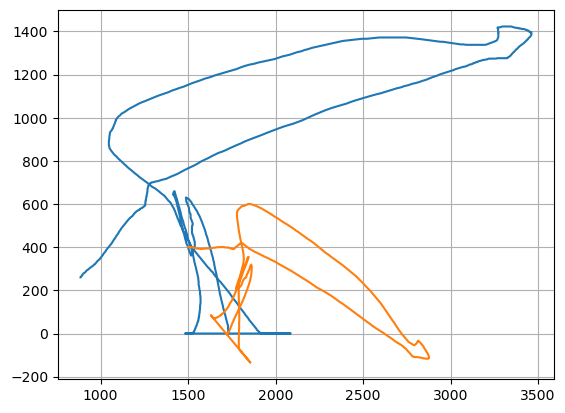

In [31]:
c = Recording.sample().sel1(klass=ContourTrack); c.coords | cut(0, 1) | transpose() | ~aS(plt.plot); print()
c.movePoint(1500, 400, True); c.coords | cut(0, 1) | transpose() | ~aS(plt.plot); plt.grid(True)

In [32]:
#export
@k1.patch(Track)
def nextTrack(self) -> Track:
    """Grabs the next track (ordered by start time) in the recording"""
    return self.recording._tracks | filt(op().startTime) | filt(op().startTime > (self.startTime or 0)) | sortF(op().startTime) | item()
@k1.patch(Recording)
def refine(self, enabled:List[int]=[1,1,0]) -> Recording:
    """Perform sensible default operations to refine the Recording.
This currently includes:

- (0) Splitting ContourTracks into multiple smaller tracks using click events
- (1) Forming words from nearby CharTracks
- (2) Removing open-close CharTracks. Basically, CharTracks that don't have a begin or end time

:param enabled: list of integers, whether to turn on or off certain features. 1 to turn on, 0 to turn off"""
    if enabled[0]: self.formWords()
    if enabled[1]: self.sel(klass=ContourTrack) | op().splitClick().all() | ignore()
    if enabled[2]: self.removeTracks(self.sel(klass=CharTrack) | ~filt(op().startTime))
    return self

In [33]:
assert Recording.sample().sel1(klass=CharTrack) | applySerial(op().nextTrack()) | head(20) | shape(0) == 20


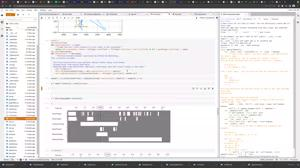
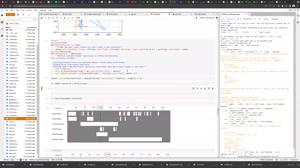
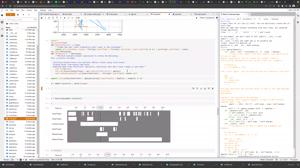
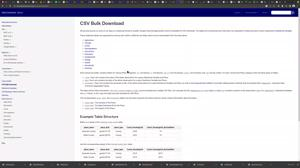
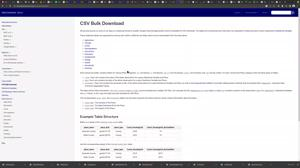
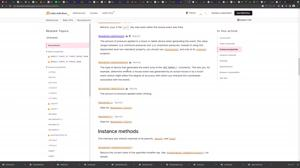
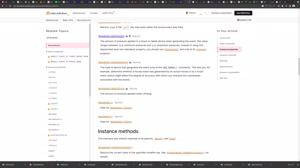
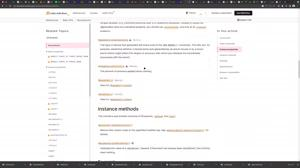
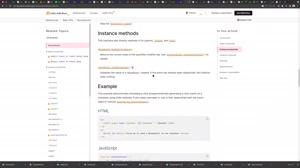
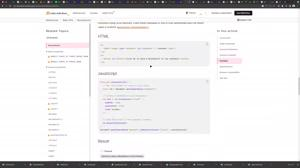
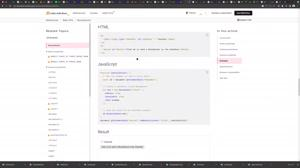
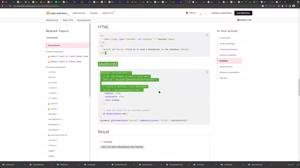
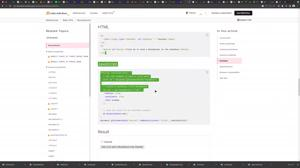
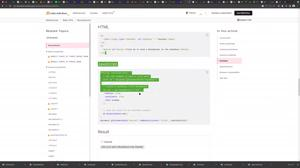
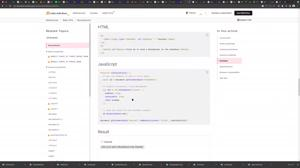
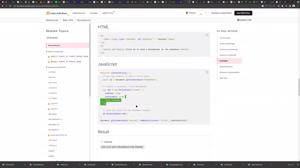
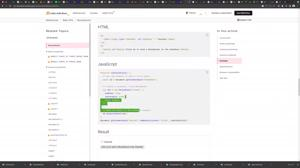
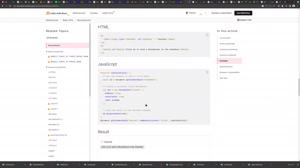
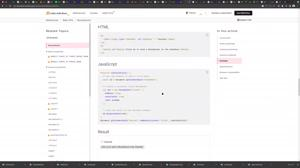
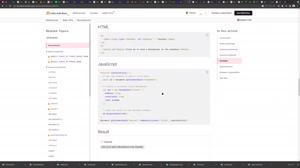
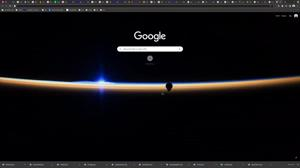
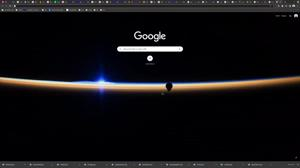
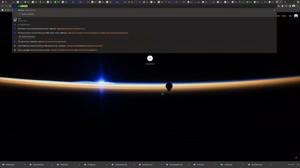
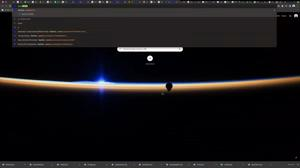
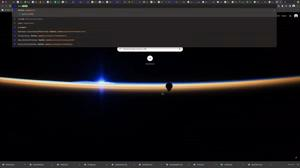
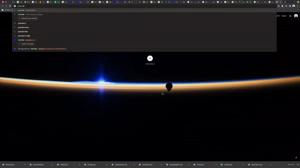
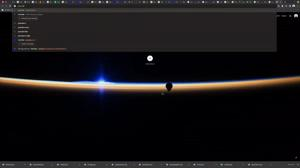
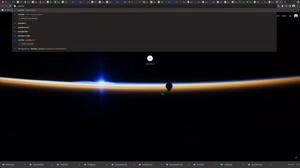
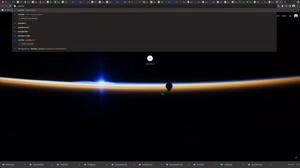
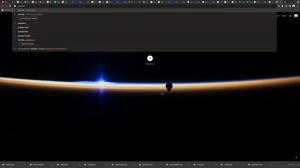
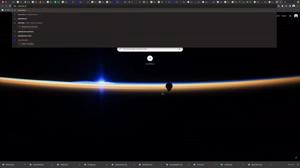
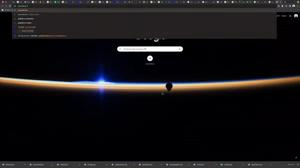
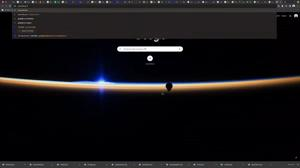
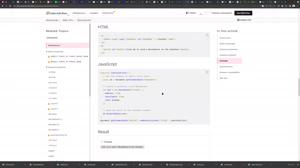
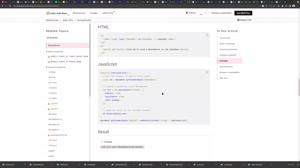
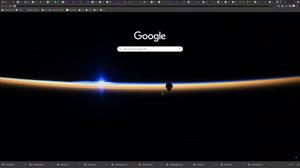
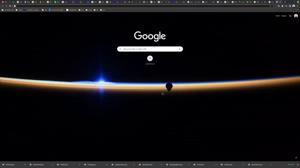
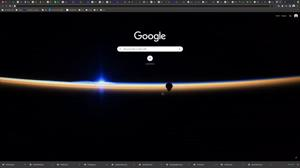
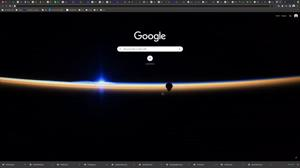
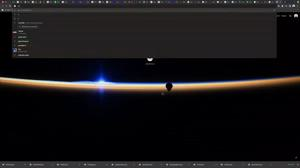

In [34]:
Recording.sample()

Also change sel's selection mechanism, so that specifying only t1 will make t2 clone itself


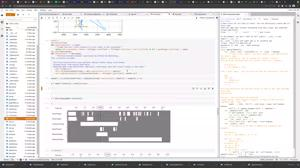
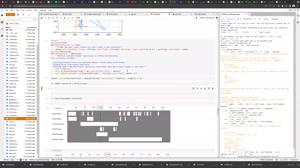
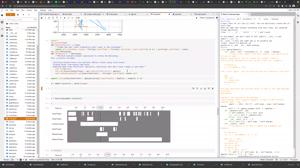
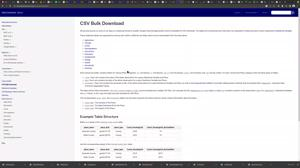
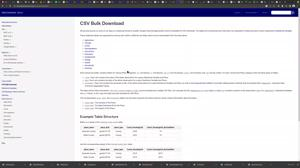
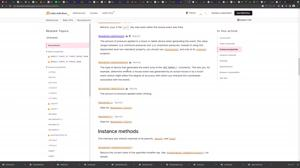
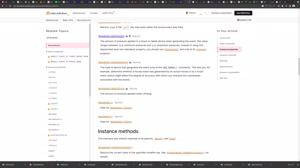
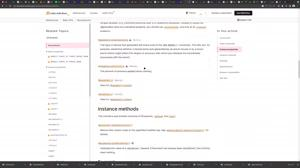
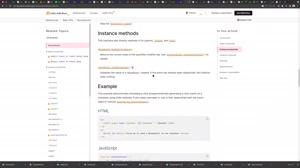
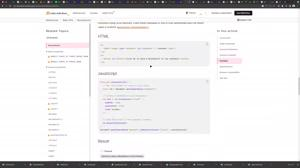
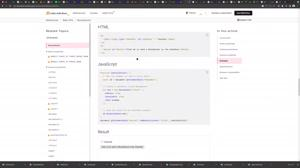
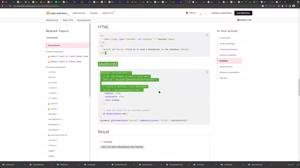
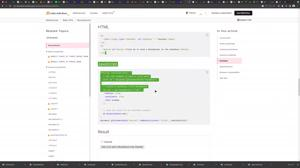
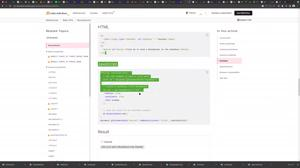
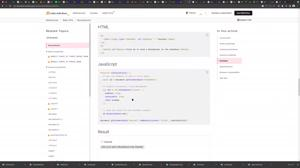
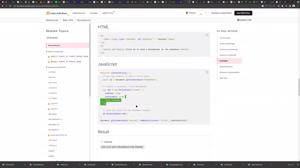
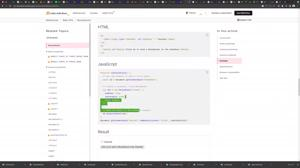
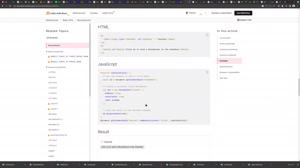
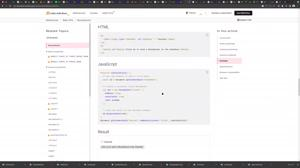
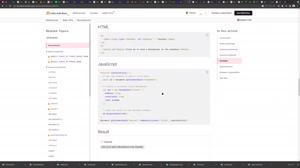
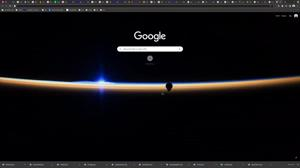
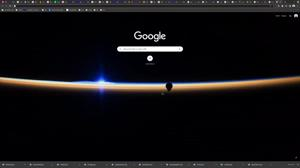
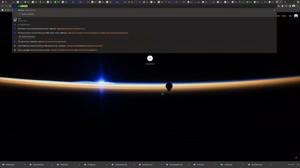
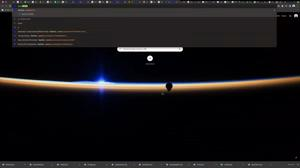
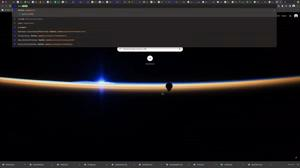
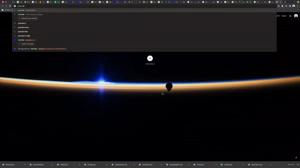
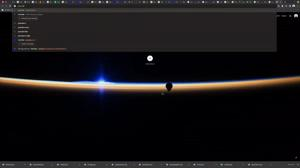
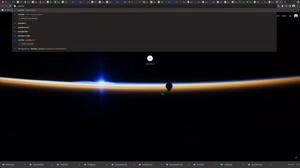
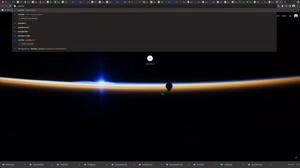
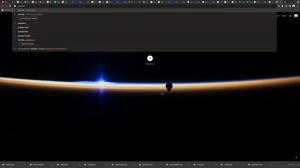
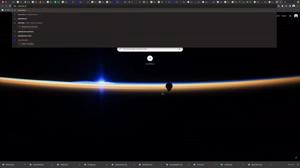
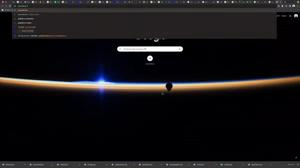
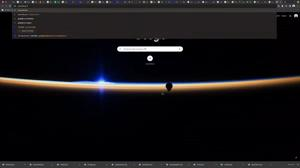
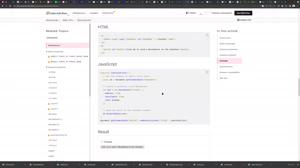
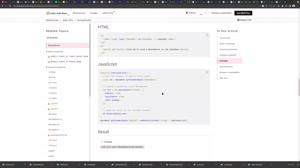
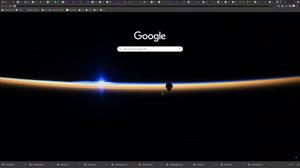
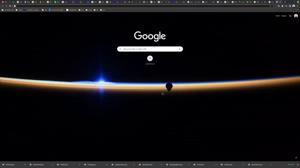
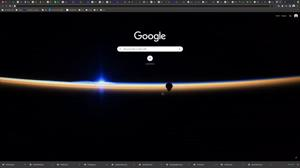
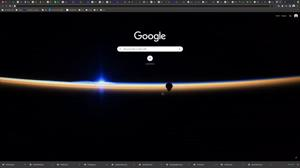
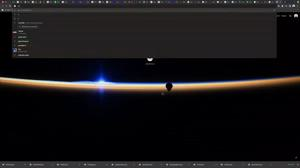

In [35]:
r = Recording.sample().refine(); assert r.sel(klass=ContourTrack) | shape(0) == 11; r


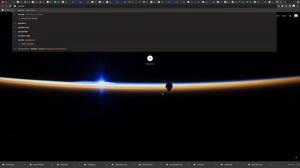
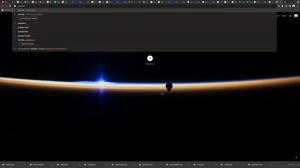
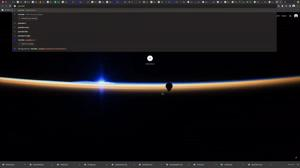
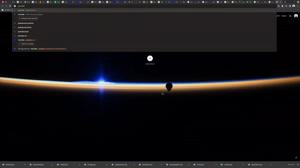
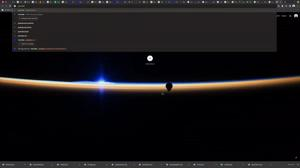
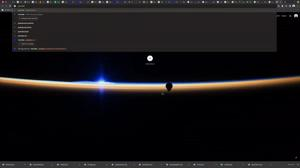
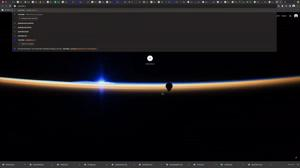
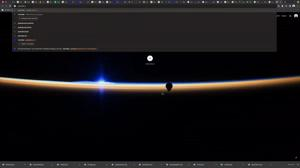
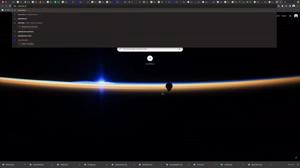
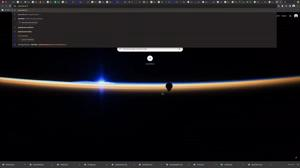
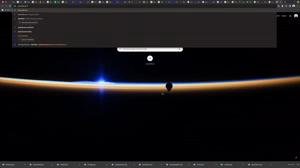
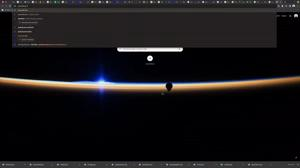
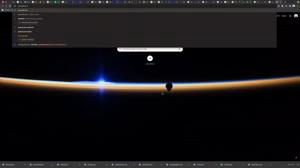
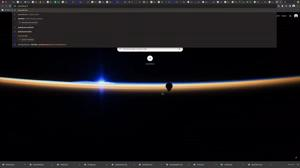
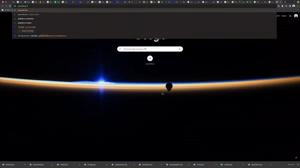
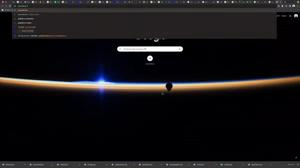
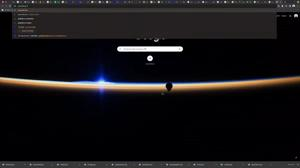
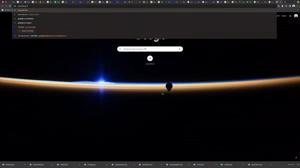
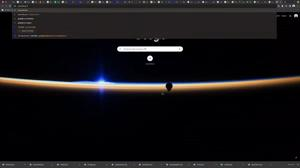
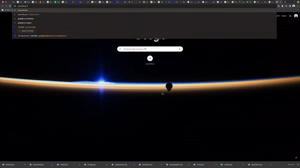
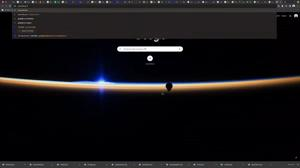
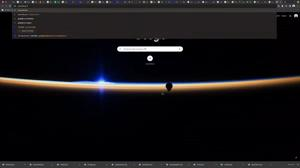
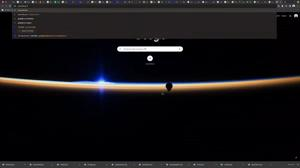
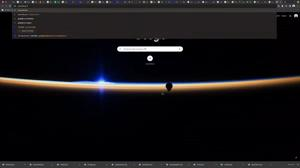
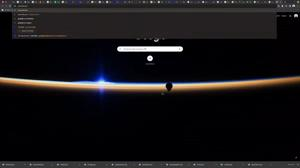
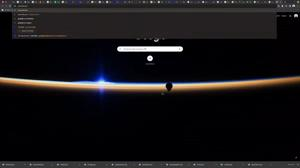
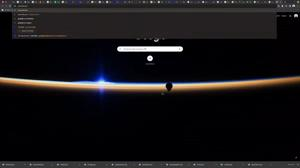
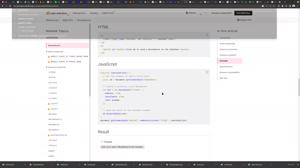
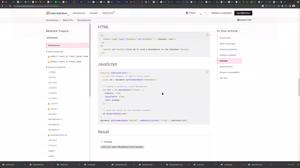
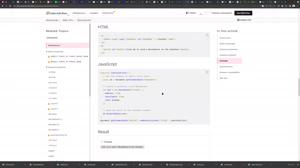
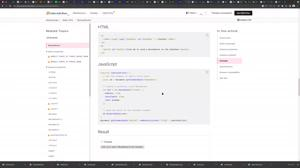
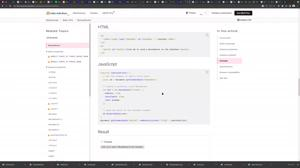
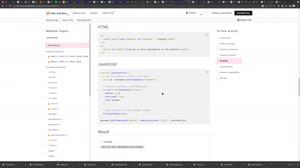
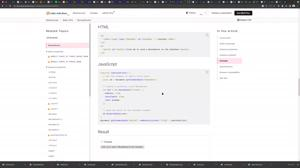
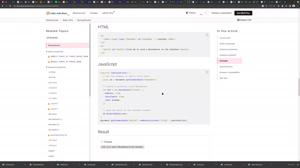
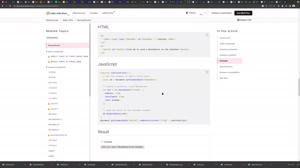
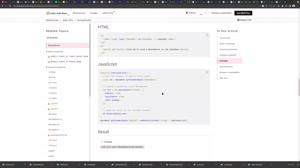
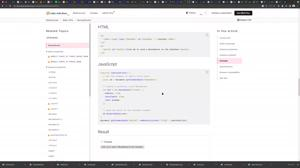
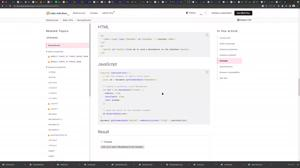
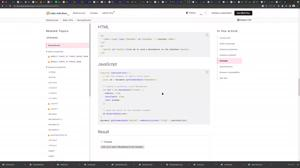
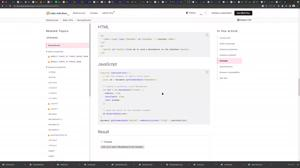
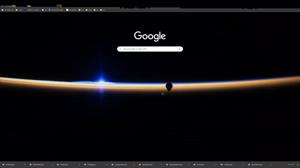
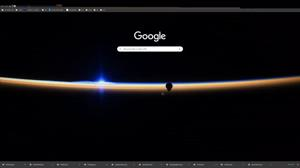
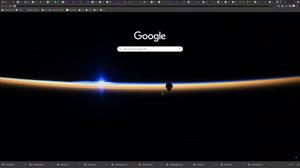
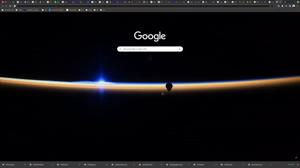
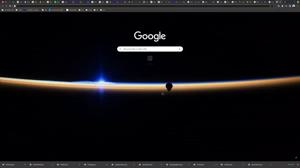
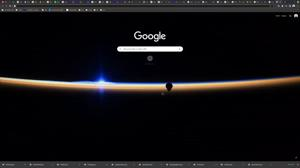
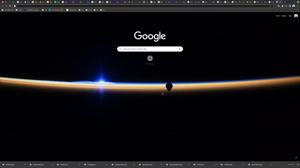
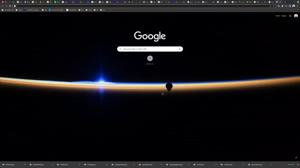
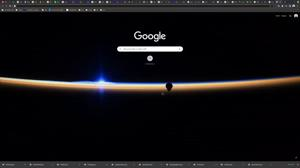
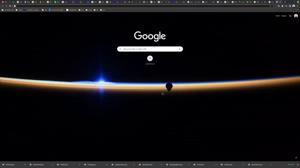
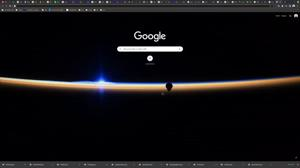
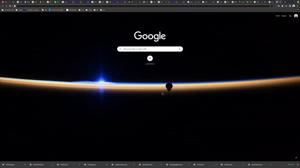
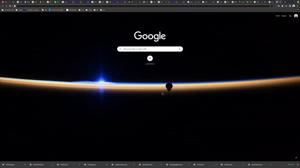
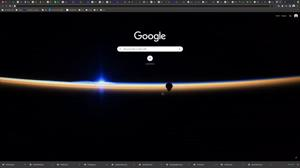
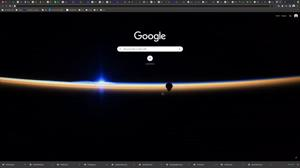
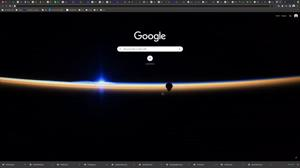
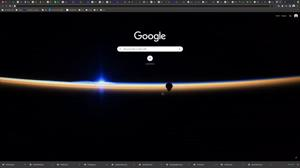
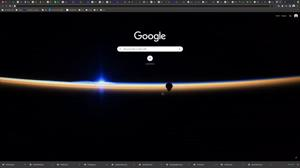
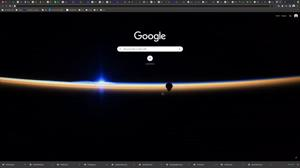
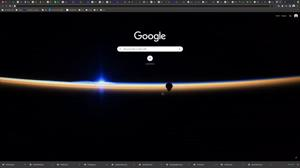
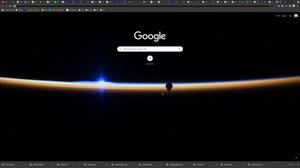
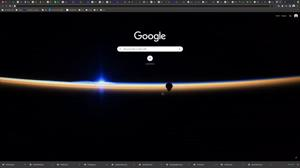
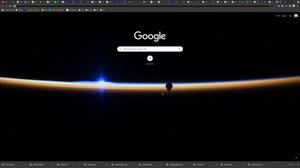
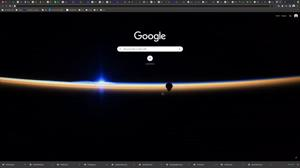
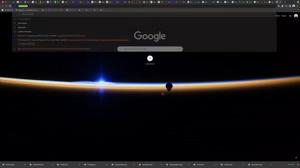
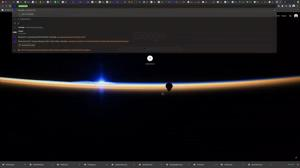
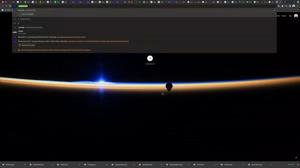
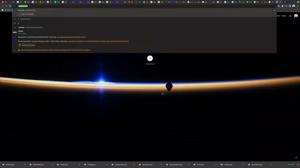
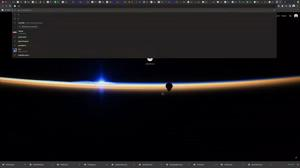
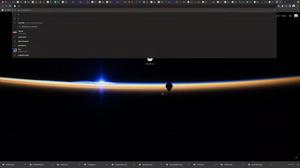
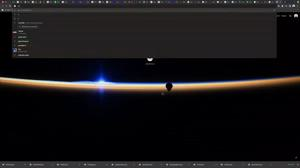
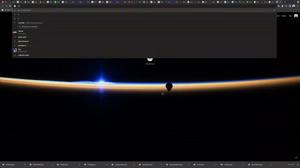
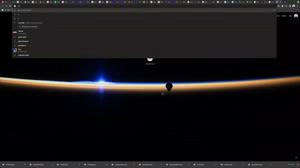
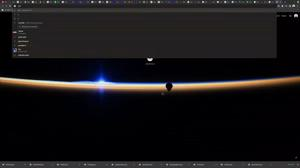
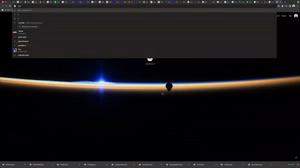
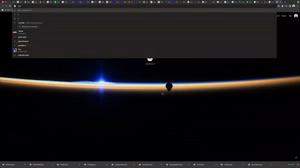
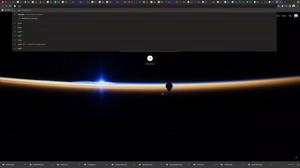
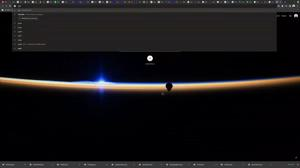

In [36]:
r.zoom(4, 10)


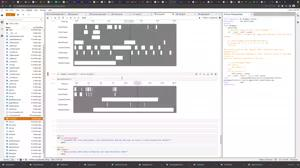
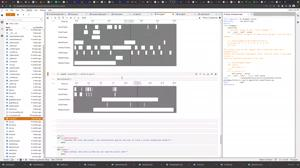
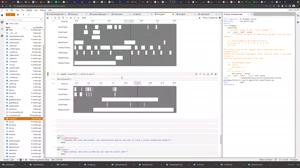
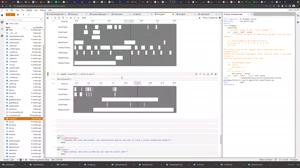
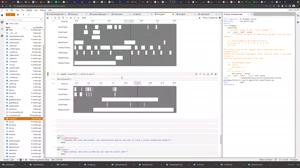
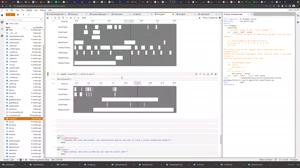
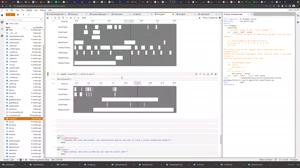
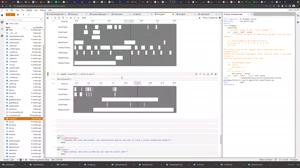
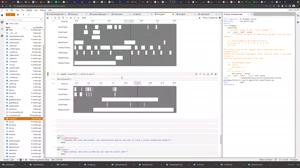
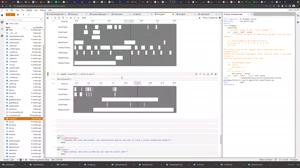
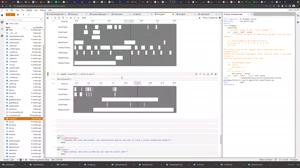
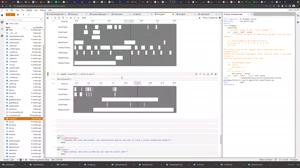
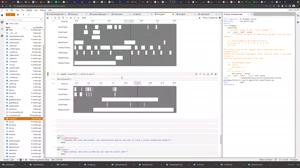
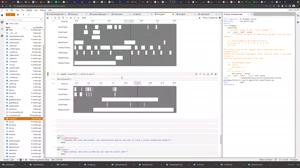
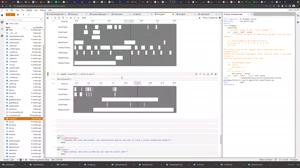
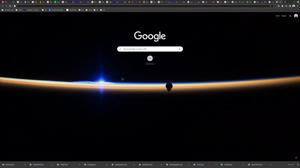
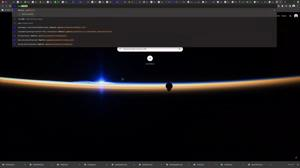
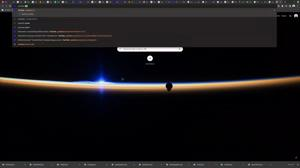
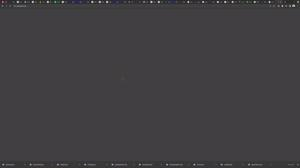
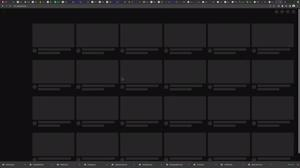
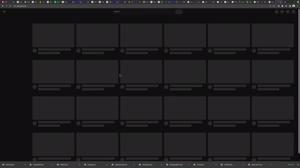
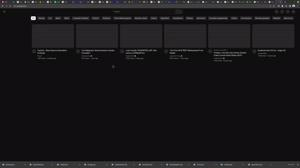
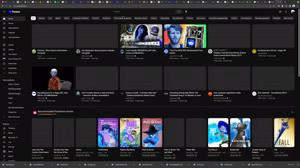
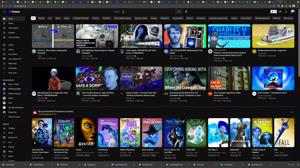
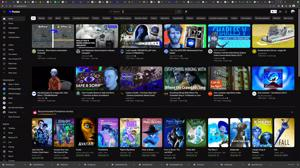
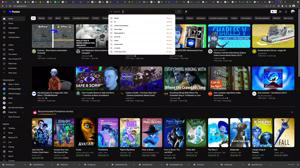
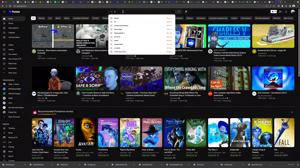
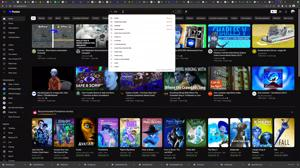
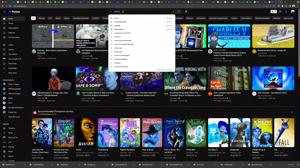
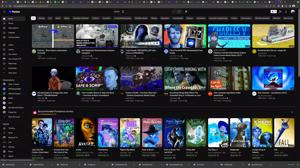
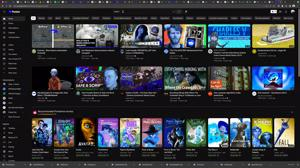
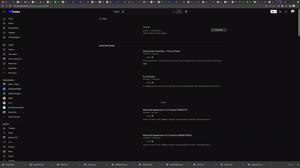
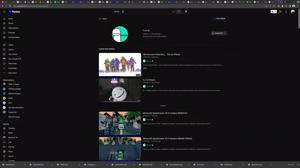
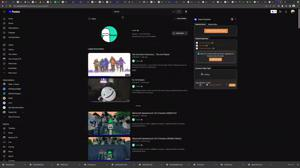
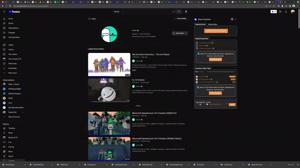
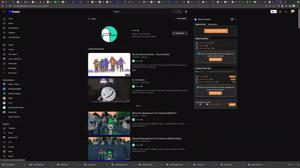
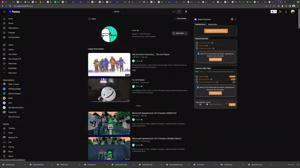
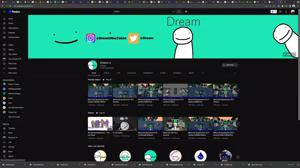
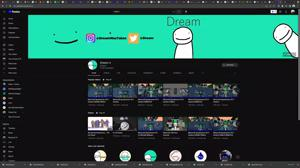
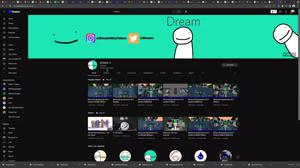
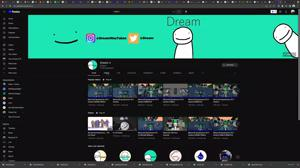

In [37]:
r = Recording(cat("dream.pth", False) | aS(dill.loads) | op()()).refine().removeTime(0.5, 4.8)
r.sel(klass=WordTrack)[1].text = "vsauce"; r

In [38]:
#export
def convBlock(inC, outC, kernel=3, stride=2, padding=1):
    return torch.nn.Sequential(torch.nn.Conv2d(inC, outC, kernel, stride, padding), torch.nn.ReLU(), torch.nn.BatchNorm2d(outC))
class skipBlock(torch.nn.Module):
    def __init__(self, inC):
        super().__init__(); self.conv1 = convBlock(inC, inC, stride=1)
        self.conv2 = convBlock(inC, inC*2)
    def forward(self, x): return ((x | self.conv1) + x) | self.conv2
class Net(torch.nn.Module):
    def __init__(self, skips:int=5):
        super().__init__()
        self.skips = torch.nn.Sequential(convBlock(3, 8), *[skipBlock(8*2**i) for i in range(skips)])
        self.avgPool = torch.nn.AdaptiveAvgPool2d([1, 1]); self.lin1 = knn.LinBlock(8 * 2**skips, 50)
        self.lin2 = torch.nn.Linear(50, 10); self.softmax = torch.nn.Softmax(dim=1)
        self.distThreshold = torch.nn.Parameter(torch.tensor(-0.5)); self.sigmoid = torch.nn.Sigmoid()
        self.headOnly = True
    def forward(self, x):
        x = x | self.skips | self.avgPool | op().squeeze() | self.lin1
        return x if self.headOnly else x | self.lin2
        x = ((x[None] - x[:,None])**2).sum(dim=-1)
        x = (x + 1e-7)**0.5 + self.distThreshold | self.sigmoid
        return x
def distNet() -> torch.nn.Module:
    """Grabs a pretrained network that might be useful in distinguishing
between screens. Example::

    net = k1ui.distNet()
    net(torch.randn(16, 3, 192, 192)) # returns tensor of shape (16, 10)"""
    net = Net(); net.load_state_dict(cat(f"{basePath}256.model.state_dict.pth", False) | aS(dill.loads))
    net.parameters() | op().requires_grad_(False).all() | ignore(); net.eval(); return net

In [39]:
net = distNet(); assert net(torch.randn(16, 3, 192, 192)) | cli.shape() == (16, 50)

In [40]:
#export
def discardTransients(it, col=None, countThres=7, regular=False): # consistent for 7 consecutive frames, then output the results
    lastRow = None; lastE = None
    yielded = False; count = 0
    for row in it:
        e = row[col] if col else row
        if e == lastE: count += 1
        else: count = 0; lastE = e; lastRow = row; yielded = False
        if count > countThres-2 and not yielded: yielded = True; yield lastRow
        elif regular: yield None
class Buffer:
    def __init__(self): self.l = deque()
    def append(self, x): self.l.append(x)
    def __next__(self): return self.l.popleft()

In [41]:
arr = [1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3]
assert discardTransients(arr, countThres=5) | deref() == [1, 3]
assert discardTransients(arr, countThres=3) | deref() == [1, 2, 3]
assert discardTransients(arr, countThres=3, regular=True) | deref() == [None, None, 1, None, None, None, None, 2, None, None, 3, None, None, None]
b = Buffer(); c = discardTransients(arr, countThres=3, regular=True); data = []
for e in arr: b.append(e); data.append(next(c))
assert data == [None, None, 1, None, None, None, None, 2, None, None, 3, None, None, None]

In [42]:
#export
np2Tensor = toImg() | aS(tf.Resize([192, 192])) | toTensor()
class MLP(nn.Module):
    def __init__(self, nClasses, **kwargs):
        super().__init__(); self.l1 = knn.LinBlock(50, nClasses); self.l2 = nn.Linear(nClasses, nClasses)
    def forward(self, xb): return xb | self.l1 | self.l2
whatever = object()
class TrainScreen:
    data: List[Tuple[int, str]]
    """Core dataset of TrainScreen. Essentially just a list of (frameId, screen name)"""
    def __init__(self, r:Recording):
        """Creates a screen training system that will train a small neural network
to recognize different screens using a small amount of feedback from the user.
Overview on how it's supposed to look like:

Setting up::

    r = k1ui.Recording(await k1ui.record(30)) # record everything for 30 seconds, and creates a recording out of it
    ts = k1ui.TrainScreen(r) # creates the TrainScreen object
    r # run this in a cell to display the recording, including StreamTrack
    ts.addRule("home", "settings", "home") # add expected screen transition dynamics (home -> settings -> home)

Training with user's feedback::

    ts.registerFrames({"home": [100, 590, 4000, 4503], "settings": [1200, 2438]}) # label some frames of the recording. Network will train for ~6 seconds
    next(ts) # display 20 images that confuses the network the most
    ts.register({"home": [2, 6], "settings": [1, 16]}) # label some frames from the last line. Notice the frame numbers are much smaller and are <20
    next(ts); ts.register({}); next(ts); ts.register({}) # repeat the last 2 lines for a few times (3-5 times is probably good enough for ~7 screens)

Evaluating the performance::

    ts.graphs() # displays 2 graphs: network's prediction graph and the actual rule graph. Best way to judge performance
    ts.l.Accuracy.plot() # actual accuracy metric while training. Network could have bad accuracy here while still able to construct a perfect graph, so don't rely much on this

Using the model::

    ts.predict(torch.randn(2, 3, 192, 192) | k1ui.distNet()) # returns list of ints. Can use ts.idx2Name dict to convert to screen names

Saving the model::

    ts | aS(dill.dumps) | file("ts.pth")

.. warning::

    This won't actually save the associated recording, because recordings are
    very heavy objects (several GB). It is expected that you manually manage
    the lifecycle of the recording."""
        self.r = r; self.data = []; # [(frame id, screen name)]
        self._aspect = self.frames | item() | op().shape[:2] | ~aS(lambda x, y: y/x)
        self._distNet = distNet(); self._rules = set(); self._trainParams = {"joinAlpha": 0, "epochs": 300}
        self._lastScreenName = None; self._screenDump = Buffer(); self._screenTransients = discardTransients(self._screenDump, regular=True)
    @property
    def _coldStart(self): return len(self.data) == 0 # whether there are any data at all to work with
    def _coldGuard(self):
        if self._coldStart: raise Exception("TrainScreen has not started yet. Run `next(ts)`, choose a few frames using `ts.register()` to access this functionality")
    def _learner(self):
        self._coldGuard(); l = k1.Learner(); l.data = self._dataF()
        l.model = MLP(len(self.name2Idx))
        l.opt = optim.AdamW([l.model.parameters(), self._distNet.parameters()] | joinStreams(), lr=3e-3)
        l.cbs.add(Cbs.LossCrossEntropy()); l.css = "none"
        l.ConfusionMatrix.categories = deref()(self.name2Idx.items()) | sort(1) | cut(0) | deref()
        l.cbs.remove("AccuracyTop5", "AccF0"); return l
    def train(self, restart=True):
        """Trains the network for a while (300 epochs/6 seconds). Will be called
automatically when you register new frames to the system

:param restart: whether to restart the small network or not"""
        if restart: self.l = self._learner();
        self.l.run(self._trainParams["epochs"])
    def trainParams(self, joinAlpha:float=None, epochs:int=None):
        """Sets training parameters.

:param joinAlpha: (default 0) alpha used in joinStreamsRandom component for each
    screen categories. Read more at :class:`~k1lib.cli.structural.joinStreamsRandom`
:param epochs: (default 300) number of epochs for each training session"""
        if joinAlpha: self._trainParams["joinAlpha"] = joinAlpha
        if epochs: self._trainParams["epochs"] = epochs
    @property
    def frames(self) -> np.ndarray:
        """Grab the frames from the first :class:`StreamTrack` from the :class:`Recording`"""
        return self.r.sel1(klass=StreamTrack).frames
    @property
    @lru_cache
    def feats(self) -> List[np.ndarray]:
        """Gets the feature array of shape (N, 10) by passing the frames
through :meth:`distNet`. This returns a list of arrays, not a giant,
stacked array for memory performance"""
        self._coldGuard(); print("Converting all frames to features using `distNet`..."); a = k1.AutoIncrement()
        res = self.frames | tee(lambda x: f"{a()}/{len(self)}").crt() | np2Tensor.all() | batched(16, True) | apply(aS(list) | aS(torch.stack) | aS(self._distNet)) | joinStreams() | aS(list)
        print(); return res
    def __len__(self): return len(self.frames)
    def _randomConsidering(self): return range(len(self)) | splitW(1, 1, 1, 1, 1) | apply(randomize(None, 42) | head(4)) | joinStreams() | aS(list)
    def __next__(self) -> "PIL.Image.Image": # show frames
        if self._coldStart: self._considering = self._randomConsidering()
        else:
            a = self.transitionScreens(False) | randomize(None, 42) | cut(0) | aS(iter)
            b = self._randomConsidering() | aS(iter); c = self._midBoundaryConsidering() | aS(iter)
            self._considering = [a, a, b, c, c, c] | apply(wrapList() | insert(yieldT | repeat(), False) | joinStreams() | randomize()) | joinStreamsRandom() | head(20) | deref()
        return self._considering | lookup(self.frames) | insertIdColumn(begin=False) | plotImgs(5, self._aspect-0.2, im=True)
    def _refreshIdx(self): self.idx2Name, self.name2Idx = self.data | cut(1) | aS(set) | insertIdColumn() | toDict() & (permute(1, 0) | toDict()) | deref()
    def register(self, d):
        """Tells the object which images previously displayed by :meth:`__next__`
associate with what screen name. Example::

    next(ts) # displays the images out to a notebook cell
    ts.register({"home": [3, 4, 7], "settings": [5, 19, 2], "monkeys": [15, 11], "guns": []})

This will also quickly (around 6 seconds) train a small neural network on all
available frames based on the new information you provided.

See also: :meth:`registerFrames`"""
        self.data = [self.data, deref()(d.items()) | apply(repeat(), 0) | transpose().all() | joinStreams() | permute(1, 0) | lookup(self._considering, 0)] | joinStreams() | sort(0) | unique(0) | deref()
        self._refreshIdx(); self.train()
    def registerFrames(self, data:Dict[str, List[int]]):
        """Tells the object which frames should have which labels.
Example::

    ts.registerFrames({"home": [328, 609], "settings": [12029], "monkeys": [1238]})

This differs from :meth:`register` in that the frame id here is the
absolute frame index in the recording, while in :meth:`register`,
it's the frame displayed by :meth:`__next__`."""
        self.data = [self.data, deref()(data.items()) | apply(repeat(), 0) | transpose().all() | joinStreams() | permute(1, 0)] | joinStreams() | sort(0) | unique(0) | deref(); self._refreshIdx(); self.train()
    def addRule(self, *screenNames:List[str]) -> "TrainScreen":
        """Adds a screen transition rule. Let's say that the transition
dynamic looks like this:

.. code-block:: text

    home <---> settings <---> account
                  ^
                  |
                  v
              shortcuts

You can represent it like this::

    ts.addRule("home", "settings", "account", "settings", "home")
    ts.addRule("settings", "shortcuts", "settings")"""
        screenNames | window(2) | apply(tuple) | apply(self._rules.add) | ignore(); return self
    def transitionScreens(self, obeyRule:bool=whatever) -> List[Tuple[int, str]]:
        """Get the list of screens (list of (frameId, screen name) tuple) that
the network deems to be transitions between screen states.

:param obeyRule: if not specified, then don't filter. If True, returns only screens that
    are part of the specified rule and vice versa"""
        self._coldGuard()
        with torch.no_grad(): transitions = self.predict(self.feats) | insertIdColumn() | aS(discardTransients, 1) | window(2, True, None) | filt(~aS(lambda x, y: not y or x[1] != y[1])) | cut(0) | lookup(self.idx2Name, 1) | deref()
        if obeyRule is whatever: return transitions
        f = inSet(self._rules, 1) if obeyRule else ~inSet(self._rules, 1)
        return transitions | window(2) | apply(transpose() | iden() + aS(tuple)) | f | transpose().all() | joinStreams() | unique(0) | deref()
    def newEvent(self, sess:WsSession, event:dict):
        if event["type"] == "stream":
            with torch.no_grad():
                name = event["frame"] | np2Tensor | op().reshape(-1, 3, 192, 192) | aS(self._distNet) | op().view(1, -1)\
                    | self.l.model | op().argmax().item() | aS(lambda x: self.idx2Name[x])
                sess.loop.create_task(sess.eventCb(sess, {"type": "screenName", "name": name}))
        if event["type"] == "screenName":
            self._screenDump.append(event["name"]); res = next(self._screenTransients)
            if res:
                sess.loop.create_task(sess.eventCb(sess, {"type": "screenTransition", "transition": (self._lastScreenName, res)}))
                self._lastScreenName = res
    def predict(self, feats:"torch.Tensor") -> List[int]:
        """Using the built-in network, tries to predict the screen name for a
bunch of features of shape (N, 10). Example::

    r = ...; ts = k1ui.TrainScreen(r); next(ts)
    ts.register({"bg": [9, 10, 11, 12, 17, 19], "docs": [5, 6, 7, 8, 0, 1, 4], "jupyter": [2, 3]})
    # returns list of 2 integers
    ts.predict(torch.randn(2, 3, 192, 192) | aS(k1ui.distNet()))"""
        self._coldGuard(); return feats | batched(128, True) | apply(aS(list) | aS(torch.stack) | aS(self.l.model) | op().argmax(1).numpy()) | joinStreams()
    def transitionGraph(self) -> "graphviz.dot.Digraph":
        """Gets a screen transition graph of the entire recording. See also: :meth:`graphs`"""
        g = k1.digraph(); self.transitionScreens() | cut(1) | window(2) | apply(tuple) | count() | cut(0, 1) | ~apply(lambda c, xy: g(*xy, label=f" {c}")) | ignore(); return g
    def ruleGraph(self) -> "graphviz.dot.Digraph":
        """Gets a screen transition graph based on the specified rules.
Rules are added using :meth:`addRule`. See also: :meth:`graphs`"""
        g = k1.digraph(); self._rules | ~apply(g) | ignore(); return g
    def graphs(self) -> viz.Carousel:
        """Combines both graphs from :meth:`transitionGraph` and :meth:`ruleGraph`"""
        return [self.transitionGraph(), self.ruleGraph()] | toImg().all() | aS(viz.Carousel)
    def labeledData(self) -> viz.Carousel:
        """Visualizes labeled data"""
        return self.data | groupBy(1) | apply(randomize(None) | head(5) | lookup(self.frames, 0)) | batched(5) | plotImgs(5, self._aspect-0.2, table=True, im=True).all() | aS(viz.Carousel)
    def __getstate__(self): d = dict(self.__dict__); del d["r"]; del d["_lastScreenName"]; del d["_screenDump"]; del d["_screenTransients"]; return d
    def __setstate__(self, d):
        self.__dict__.update(d); self._lastScreenName = None; self._screenDump = Buffer()
        self._screenTransients = discardTransients(self._screenDump, regular=True)
    def correctRatio(self):
        """Ratio between the number of screens that is in a valid transition and
ones that isn't in a valid transition. Just a quick metric to see how well the
network is doing. The higher the number, the better it is"""
        return len(self.transitionScreens(True))/len(self.transitionScreens(False))

In [43]:
#export
def fillIn(n, states):
    iS = 0 # index of states
    state = None; nextI, nextS = states[iS]
    for i in range(n):
        if i >= nextI:
            iS += 1; state = nextS
            if iS < len(states): nextI, nextS = states[iS]
        yield [i, state]
def blocks(it):
    lastIs = []; lastE = None
    for i, e in it:
        if e != lastE:
            if lastE is not None: yield min(lastIs), max(lastIs), lastE
            lastIs = []; lastE = e
        lastIs.append(i)
    yield min(lastIs), max(lastIs), lastE
@k1.patch(TrainScreen)
def _dataF(self, bs=64):
    self._coldGuard(); v1 = fillIn(len(self), self.data) | filt(op(), 1) # old version. A bit more liveral than v2, and will accidentally auto label wrongly from time to time
    v2 = blocks(self.data) | ~apply(lambda x, y, z: [range(x, y+1), z | repeat()] | transpose()) | joinStreams()
    js = deref() | aS(lambda xs: xs | apply(repeatFrom() | randomize()) | joinStreamsRandom(self._trainParams["joinAlpha"], xs | apply(len) | deref())) # joinStreams
    return v2 | randomize(None) | groupBy(1) | filt(lambda x: len(x) > 1) | splitW().all() | transpose()\
        | apply(js | lookup(self.feats, 0) | lookup(self.name2Idx, 1) | batched(bs)\
                | apply(transpose() | (aS(list) | aS(torch.stack)) + toTensor(int))
               ) | stagger.tv(1024/bs) | aS(list)

In [44]:
assert fillIn(10, [[2, "a"], [5, "b"], [8, "d"]]) | cut(1) | deref() == [None, None, 'a', 'a', 'a', 'b', 'b', 'b', 'd', 'd']
assert blocks([[2, "a"], [5, "a"], [7, "b"], [10, "c"], [20, "c"]]) | deref() == [[2, 5, 'a'], [7, 7, 'b'], [10, 20, 'c']]

In [45]:
#export
def midBounds(it): # to grab data samples that's in between blocks. Aka the really confusing case in-between transitions, so that the user can guide it effectively
    lastI = 0; lastE = None
    for i, e in it:
        if e != lastE: yield (i + lastI)//2, i-lastI, lastE; lastE = e
        lastI = i
    return it
@k1.patch(TrainScreen)
def _midBoundaryConsidering(self): return midBounds(self.data) | ~head(1) | ~sort(1) | cut(0)

In [46]:
assert [[1, "a"], [2, "a"], [10, "c"]] | aS(midBounds) | deref() == [[0, 1, None], [6, 8, 'a']]
assert [[1, "a"], [10, "a"], [100, "c"], [200, "d"]] | aS(midBounds) | deref() == [[0, 1, None], [55, 90, 'a'], [150, 100, 'c']]

Converting all frames to features using `distNet`...
13930/13931, 16s elapsed
Progress: 100%, epoch: 299/300 (52.69 epochs/s), batch:  15/16 (843.0 batches/s), elapsed:   5.69s, remaining:    0.0s, loss: 0.21826379001140594             

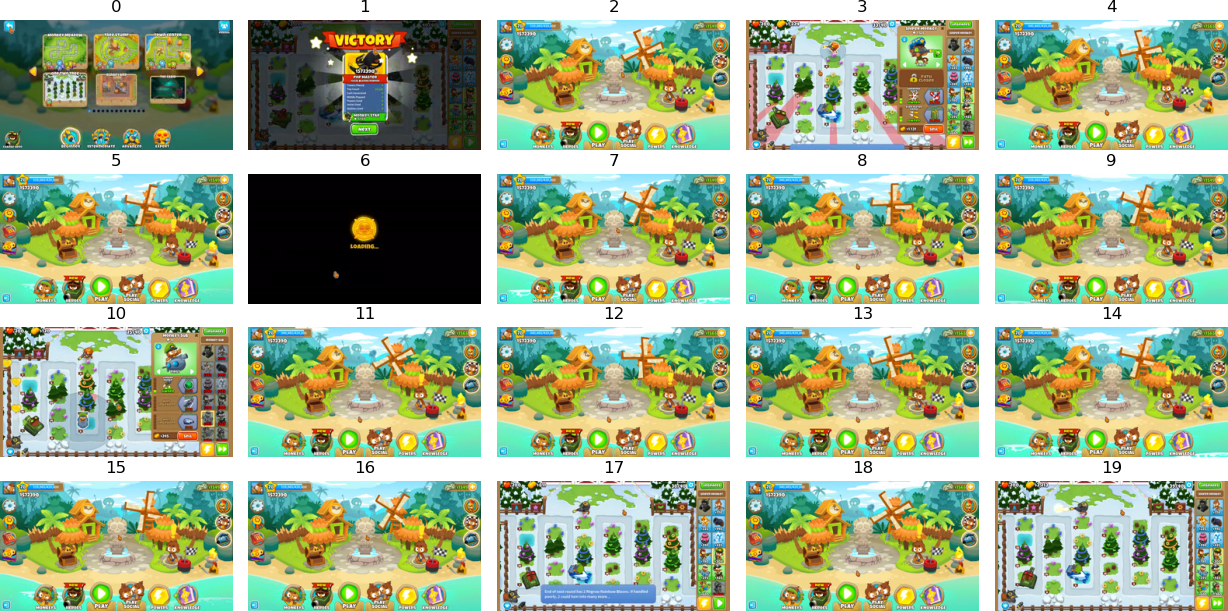

In [47]:
ts = cat.pickle("~/hdd/data/screen/btd6/3.pth") | aS(list) | aS(Recording) | aS(TrainScreen)
ts.addRule("home", "match-0", "match-1", "match-2", "loading", "match", "victory", "victory-1", "loading", "home")
ts.addRule("match-2", "match").addRule("victory-1", "home")
ts.registerFrames({"home": [1, 414, 12118, 12388], "match-0": [460, 598], "match-1": [621, 644], "match-2": [667, 685], "match": [759, 11728], "loading": [713, 736, 12088], "victory": [11758, 11878], "victory-1": [11938, 12058]})
next(ts)

In [48]:
assert ts.predict(torch.randn(2, 3, 192, 192) | aS(distNet())) | shape(0) == 2
assert ts.l.Accuracy.valid[-30:].mean() > 0.4
ts.register({"match-0": [7], "match-1": [9], "match-2": [8], "match": [0, 3, 6, 13], "loading": [], "home": [1, 2, 11, 12], "victory": []})

Progress: 100%, epoch: 299/300 (54.99 epochs/s), batch: 15/16 (879.89 batches/s), elapsed:   5.45s, remaining:   0.0s, loss: 0.6094493269920349              

In [1]:
!../../export.py k1ui/main

Current dir: /home/kelvin/repos/labs/k1lib, /home/kelvin/repos/labs/k1lib/k1lib/k1ui/../../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.2.6
Uninstalling k1lib-1.2.6:
  Successfully uninstalled k1lib-1.2.6
running install
/home/kelvin/anaconda3/envs/torch/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/torch/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
writing dependency_links to k1lib.egg-info/dependency_links.txt
writing requirements to k1lib.egg-info/requires.txt
writing top-level names to k1lib.egg-info/top_le